# NER Model Comparison

This notebook looks at the evaluation results of the different NER models by the full detailed metrics.

In [36]:
import os, sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

FFOSSILS_PALETTE = sns.color_palette(["#677e52", "#8fbed5", "#1f3a5f", "#005a3c", "#4c2f27",  "#b8864b"])

# sns.set_context("talk")

In [37]:
models_path = os.path.join(os.getcwd(), os.pardir, "results", "ner")

In [38]:
def load_model_evaluation_results(models_path:str, results_type:str="val"):

    results_df = pd.DataFrame()

    for model in os.listdir(models_path):
        if os.path.isdir(os.path.join(models_path, model)):
            results_path = os.path.join(models_path, model) #, "evaluation-results"
            for file in os.listdir(results_path):
                if (file.endswith("classification_results.json")) & (results_type in file):

                    results_dict = json.load(
                        open(os.path.join(results_path, file), "r")
                    )

                    parsed_dict = {}
                    
                    for key, value in results_dict.items():
                        # original entity and token based results
                        if (key == "token") | (key == "entity"):
                            for k, v in value.items():
                                # print(f"key: {key} k: {k} v: {v}")
                                if k == "classification_report":
                                    for kk, vv in v.items():
                                        # print(f"\tkk: {kk} vv: {vv}")
                                        for kkk, vvv in vv.items():
                                            # print(f"\t\tkkk: {kkk} vvv: {vvv}")
                                            parsed_dict[f"{key}_{kk}_{kkk}".replace(" ", "-")] = [vvv]
                                else:
                                    parsed_dict[f"{key}_{k}"] = [v]
                        # overall model results with new metrics
                        elif key == "overall_results":
                            for k, v in value.items():
                                # print(f"key: {key} k: {k} v: {v}")
                                for kk, vv in v.items():
                                    # print(f"\tkk: {kk}, vv: {vv}")
                                    if kk in ["precision", "recall", "actual", "possible"]:
                                        parsed_dict[f"overall_{k.replace('_', '-')}_{kk}"] = [vv]
                                    else:
                                        parsed_dict[f"overall_{k.replace('_', '-')}_percent-{kk}"] = [vv / v["possible"]]
                                        parsed_dict[f"overall_{k.replace('_', '-')}_{kk}"] = [vv] 
                        # overall results by each tag group
                        elif key == "overall_results_by_tag":
                            for label, v in value.items():
                                # print(f"key: {key} label: {label} v: {v}")
                                for eval_type, vv in v.items():
                                    # print(f"\teval_type: {eval_type} vv: {vv}")
                                    for result, vvv in vv.items():
                                        # print(f"\t\tresult: {result}, vvv: {vvv}")
                                        if result in ["precision", "recall", "actual", "possible", "spurious"]:
                                            parsed_dict[f"{label}_{eval_type.replace('_', '-')}_{result}"] = [vvv]
                                        else:
                                            parsed_dict[f"{label}_{eval_type.replace('_', '-')}_percent-{result}"] = [vvv / vv["possible"]]
                                            parsed_dict[f"{label}_{eval_type.replace('_', '-')}_{result}"] = [vvv]
                        # add in the counts of each entity type
                        elif key == "entity_counts":
                            for k, v in value.items():
                                # print(f"key: {key} k: {k} v: {v}")
                                parsed_dict[f"{k}_count"] = [v]
                        elif key == "num_tokens":
                            parsed_dict[f"{key}"] = [value]

                    model_results = pd.DataFrame(parsed_dict)

                    model_results["model"] = model.replace("-", " ").title()
                    results_df = pd.concat([results_df, model_results])

    return results_df

# Model Evaluation Results

The following section highlights the results of each model via different metrics.

## Loading Model Evaluation Results

In [39]:
eval_results = load_model_evaluation_results(models_path, results_type="test")

In [40]:
eval_results.head()

,token_accuracy,token_f1,token_recall,token_precision,token_AGE_precision,token_AGE_recall,token_AGE_f1-score,token_AGE_support,token_ALTI_precision,token_ALTI_recall,...,num_tokens,O_count,AGE_count,REGION_count,GEOG_count,TAXA_count,EMAIL_count,SITE_count,ALTI_count,model
0,0.947889,0.386678,0.252172,0.828700,0.789474,0.090452,0.162308,995,0.846154,0.271605,...,64900,60526,995,1067,58,1476,21,676,81,Baseline Regex
0,0.971926,0.775632,0.799040,0.753558,0.889746,0.811055,0.848580,995,0.680412,0.814815,...,64900,60526,995,1067,58,1476,21,676,81,Bert Multilanguage Finetuned V1
0,0.971757,0.780259,0.834934,0.732304,0.886486,0.824121,0.854167,995,0.629630,0.839506,...,64900,60526,995,1067,58,1476,21,676,81,Roberta Finetuned V3
0,0.964670,0.751416,0.844416,0.676868,0.791358,0.917024,0.849569,699,0.609091,0.930556,...,45004,41861,699,871,159,989,15,338,72,Roberta Finetuned V5
0,0.965642,0.767113,0.839793,0.706010,0.829424,0.893226,0.860144,871,0.519553,0.762295,...,49304,45821,871,1096,212,850,17,315,122,Roberta Finetuned V6


In [41]:
eval_results.model.unique()

array(['Baseline Regex', 'Bert Multilanguage Finetuned V1',
       'Roberta Finetuned V3', 'Roberta Finetuned V5',
       'Roberta Finetuned V6', 'Roberta Finetuned V7', 'Spacy Ner V1',
       'Spacy Transformer V3', 'Specter2 Finetune V3'], dtype=object)

In [42]:
eval_results.columns

Index(['token_accuracy', 'token_f1', 'token_recall', 'token_precision',
       'token_AGE_precision', 'token_AGE_recall', 'token_AGE_f1-score',
       'token_AGE_support', 'token_ALTI_precision', 'token_ALTI_recall',
       ...
       'num_tokens', 'O_count', 'AGE_count', 'REGION_count', 'GEOG_count',
       'TAXA_count', 'EMAIL_count', 'SITE_count', 'ALTI_count', 'model'],
      dtype='object', length=518)

## Select which Models to Include in the Comparison

In [62]:
latest_models = [
    'Bert Multilanguage Finetuned V1',
    'Roberta Finetuned V6', 
    'Spacy Transformer V3',
    'Specter2 Finetune V3',
    "Spacy Ner V1",
    "Baseline Regex"
]

In [63]:
relevant_results = eval_results[eval_results.model.isin(latest_models)]

# clean up V numbers from names and remove Finetune from names
relevant_results["model"] = (
    relevant_results.model
    # .str.replace("V\d", "", regex=True)
    .str.replace("bert", "BERT")
    .str.replace("Bert", "BERT")
    .str.replace("spacy", "spaCy")
    .str.replace("Spacy", "spaCy")
    .str.replace("Finetuned", "")
    .str.replace("Finetune", "")
    .str.replace("Ner", "NER")
    .str.replace("  ", " ")
    .str.strip()
)

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\74837738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_results["model"] = (


In [64]:
relevant_results.model.unique()

array(['Baseline Regex', 'BERT Multilanguage V1', 'RoBERTa V6',
       'spaCy NER V1', 'spaCy Transformer V3', 'Specter2 V3'],
      dtype=object)

# Number of Entities in Dataset

In [65]:
def plot_distribution_of_entities(
        results_df:pd.DataFrame, 
        model:str):

    entity_columns = [c for c in results_df if "count" in c and c != "O_count"]

    flat_df = results_df.query("model == @model").melt(
        # id_vars=["model"],
        value_vars=entity_columns,
        value_name = "count",
        var_name="entity"
    ).sort_values(["count"], ascending = False)

    flat_df["entity"] = flat_df.entity.str.replace("_count", "")

    fig, ax = plt.subplots(figsize = (10,8))
    ax = sns.barplot(
        x = "entity",
        y = "count",
        # hue="entity",
        data = flat_df,
        ax = ax
    )

    ax.set_title(f"Entity Counts in Data Set\nTotal Token Count: {results_df.query('model == @model').iloc[0].num_tokens}")
    ax.bar_label(ax.containers[0], fmt='%.0f')
    ax.set_xlabel("Entity Type")
    ax.set_ylabel("Number of Occurences")
    plt.show()

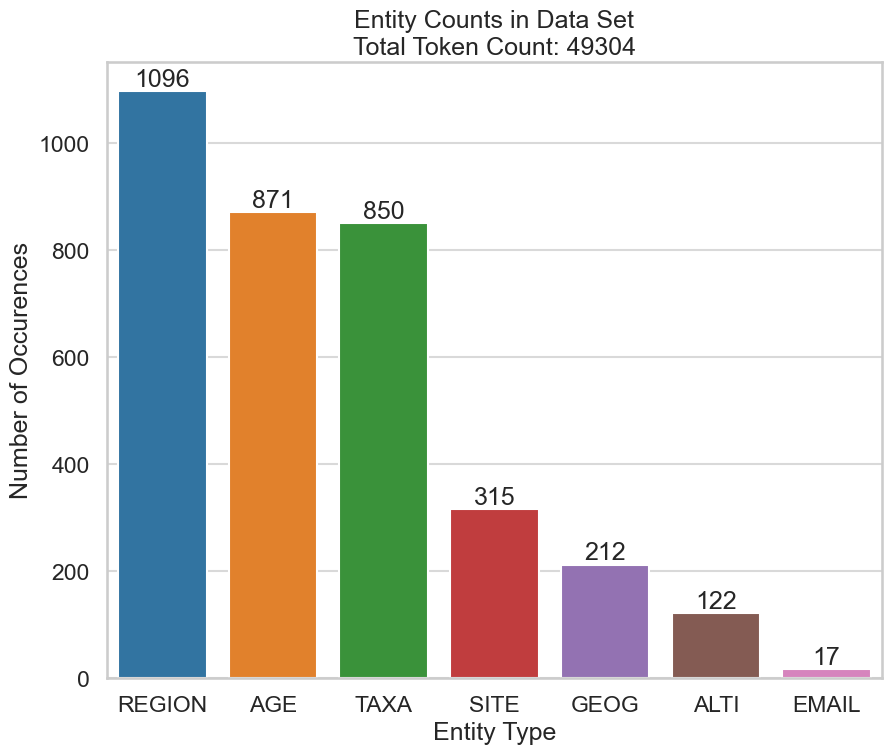

In [66]:
plot_distribution_of_entities(relevant_results, "RoBERTa V6")

## Function to Plot All Models Results

In [67]:
def plot_model_metric_comparison(
        results_df:pd.DataFrame, 
        metrics:list, 
        fig_height:int=8, 
        fig_width:int=8, 
        sort_ascending:bool=False,
        value_type="percent"
        ):

    metrics_formatted = [metric.replace("_", " ").title() for metric in metrics]

    # flatten the results_df 
    flat_df = results_df.melt(
        id_vars=["model"],
        value_vars=metrics,
        value_name = "score",
        var_name="metric"
    )

    # multiply scores by 100 
    if value_type == "percent":
        flat_df.loc[:, "score"] = flat_df.score * 100

    # format the metric names
    flat_df.loc[:, "metric"] = flat_df.metric.str.replace("_", " ").str.title()

    # plot token level recall by model using seaborn
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    # sns.set_theme(style="whitegrid")
    ax = sns.barplot(
        y="model",
        x="score",
        hue="metric",
        data=flat_df,
        order=flat_df.iloc[flat_df[flat_df['metric'] == metrics_formatted[0]]['score'].sort_values(ascending=sort_ascending).index]['model'],
        palette=FFOSSILS_PALETTE,
        ax=ax,
    )
    ax.set_title(
        f"Model Performance Comparison\n", #\nMetrics: {', '.join(metrics_formatted)}",
        fontsize=20,
        fontweight="bold",
    )
    if value_type == "percent":
        for i in range(0, len(metrics)):
            ax.bar_label(ax.containers[i], fmt='%.1f%%', fontsize=16, padding=3)

        xtick_labels = [f"{int(x*2)}%" for x in ax.get_xticks()]

        # xtick_labels = ["" for x in ax.get_xticks()]
        ax.set_xticklabels(xtick_labels)
    elif value_type == "count":
        for i in range(0, len(metrics)):
            ax.bar_label(ax.containers[i], fmt='%d', fontsize=16, padding=3)

        xtick_labels = [f"{int(x)}" for x in ax.get_xticks()]

        # xtick_labels = ["" for x in ax.get_xticks()]
        ax.set_xticklabels(xtick_labels)
    else:
        raise ValueError(f"Invalid value_type must be one of 'count' or 'percent', got: {value_type}")

    ax.set_xlabel(None)

    ax.set_ylabel(None)
    ax.set_xlim(0.0, max(100, flat_df.score.max()))
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=16) #bbox_to_anchor=(1.02, 0.5),
    sns.despine(bottom=True)
    plt.show()

# Entity & Token Based Recall

The entity and token based recall are the most important metrics for the NER task because it indicates how many entities were missed at inference time. The following section shows the results of the different models.

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


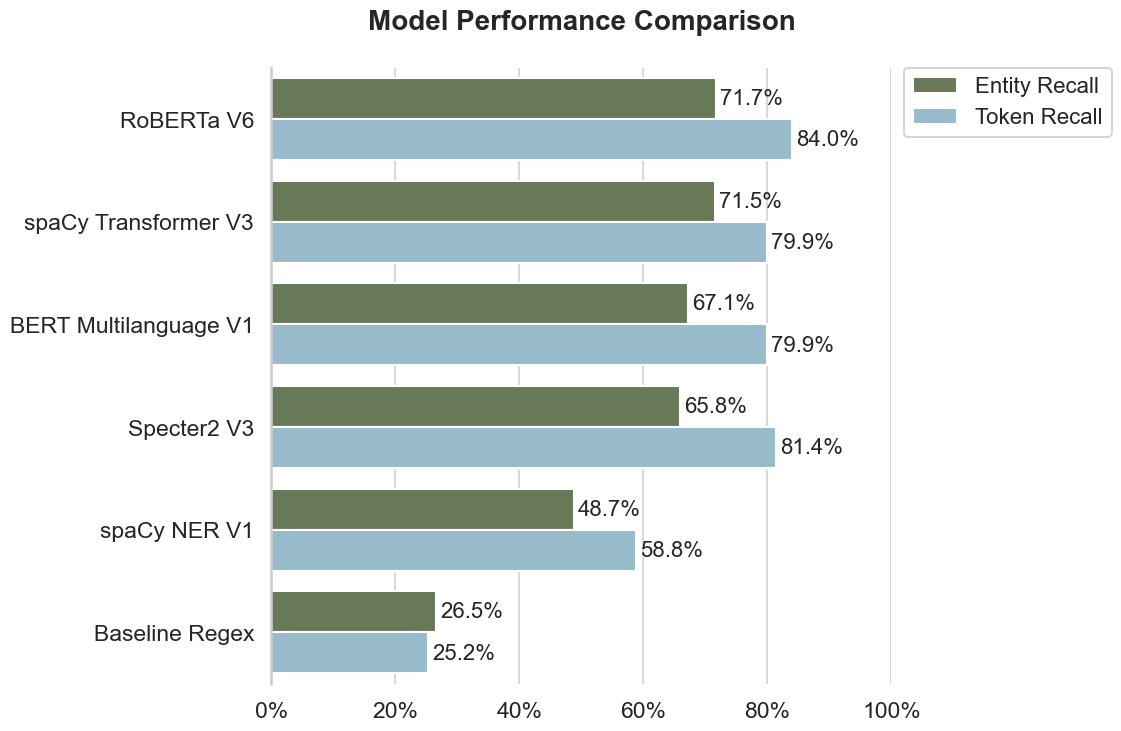

In [68]:
sns.set_style("whitegrid", 
              rc={
                  # used to match presentation cream background color
                #   'figure.facecolor':'#FFFFF0', 
                #   'axes.facecolor':'#FFFFF0',
                  # set grid lines to be grey
                    'grid.color': '.85',
                  })
sns.set_context("talk")

plot_model_metric_comparison(relevant_results, ["entity_recall", "token_recall"])

## Entity & Token Precision

This indicates how many entities were correctly identified and the higher values indicate fewer false positives, i.e. fewer entities that need to be deleted by reviewers.

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


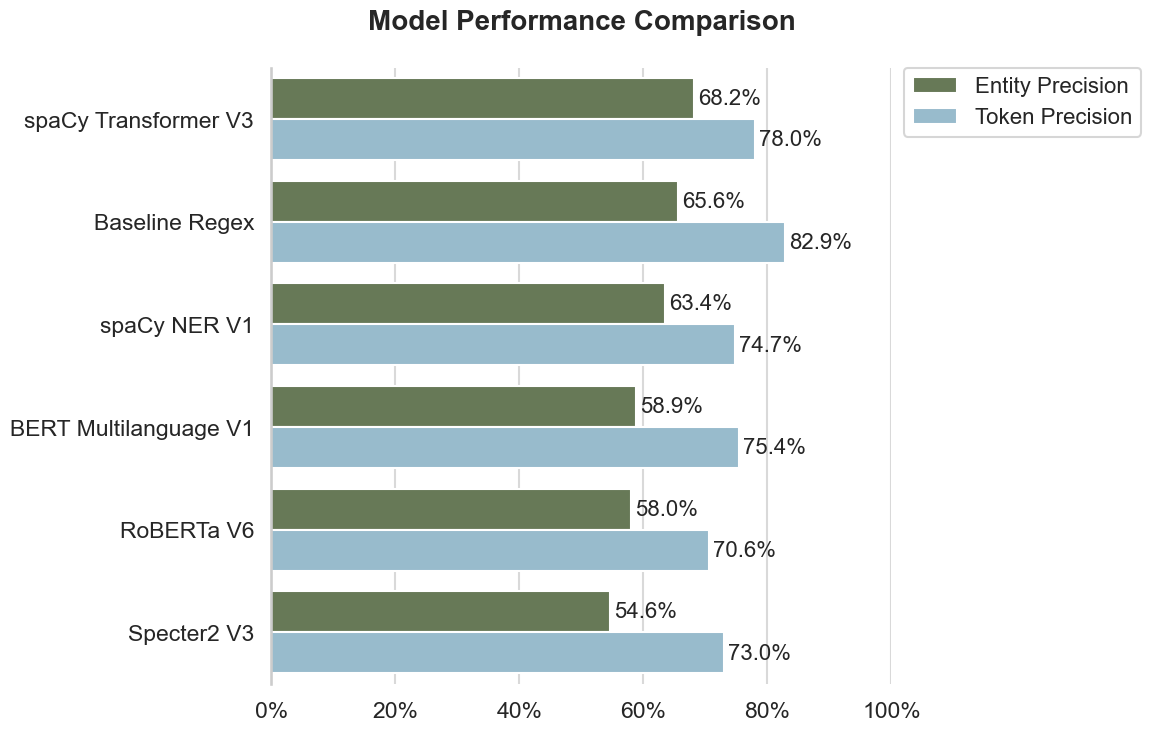

In [69]:
plot_model_metric_comparison(relevant_results, ["entity_precision", "token_precision"])

## Entity & Token F1 Score

This shows how balanced the precision and recall are for the entity and token based metrics. The higher the score the better.

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


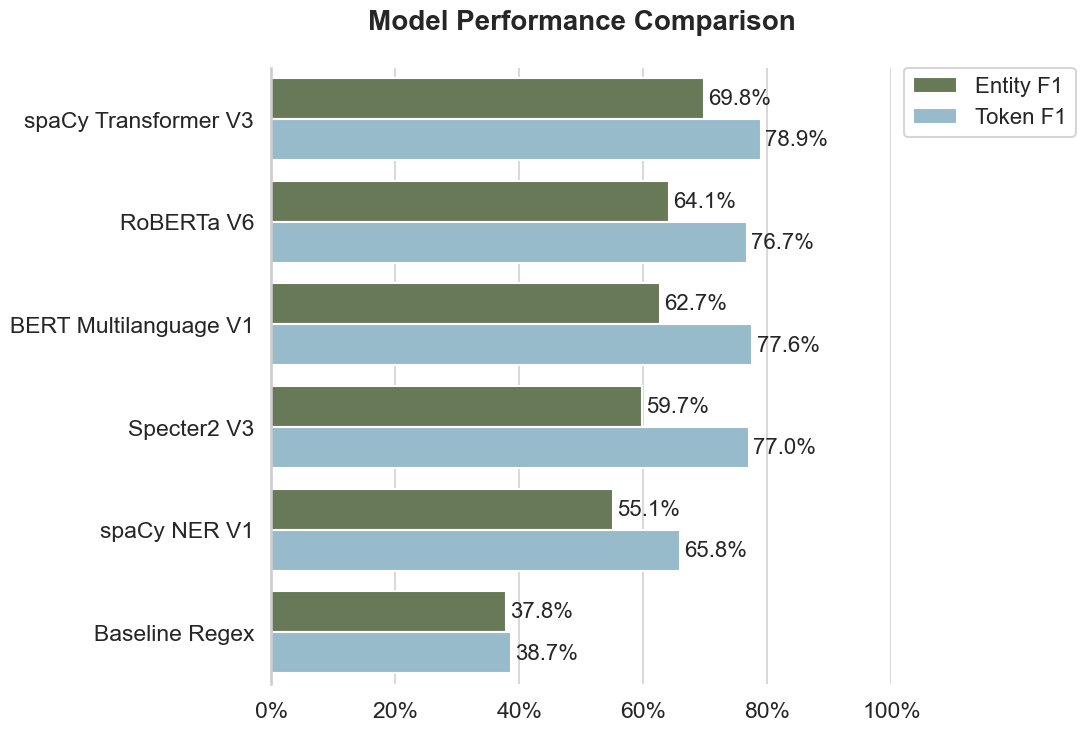

In [70]:
plot_model_metric_comparison(relevant_results, ["entity_f1", "token_f1"])

## Recall & Precision by Entity Type

Below shows the difference between models on each entity type.

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


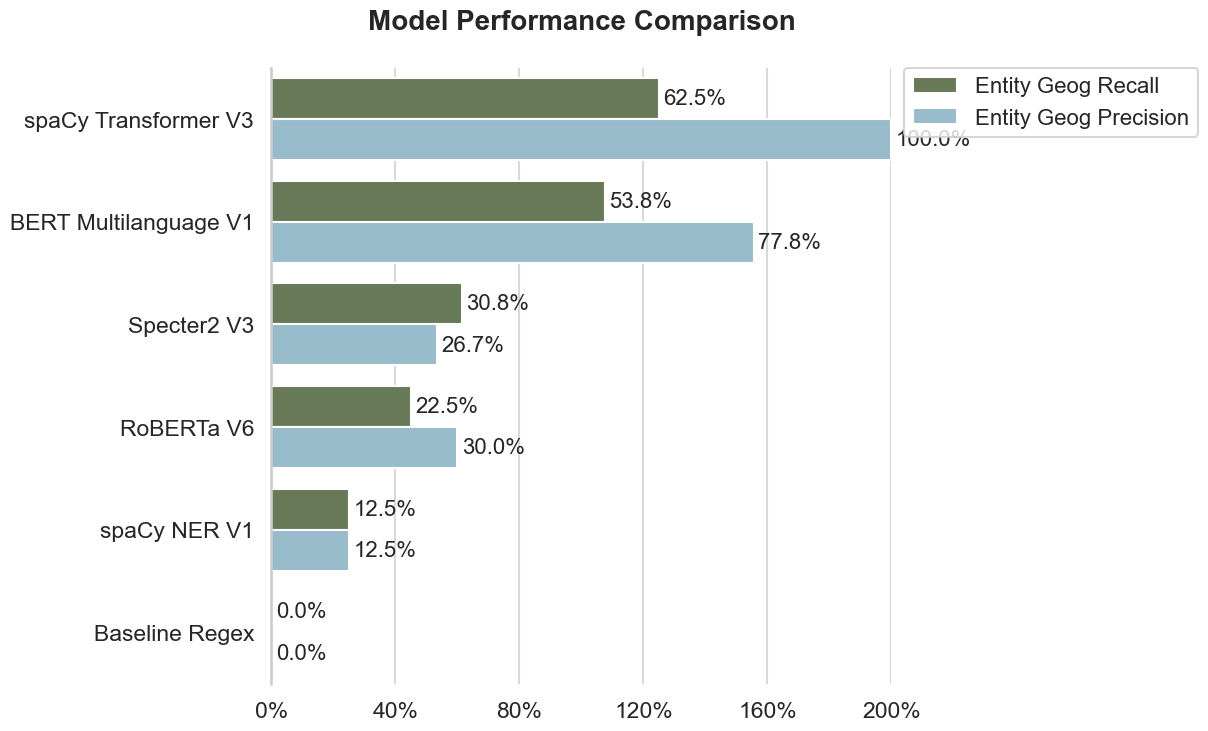

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


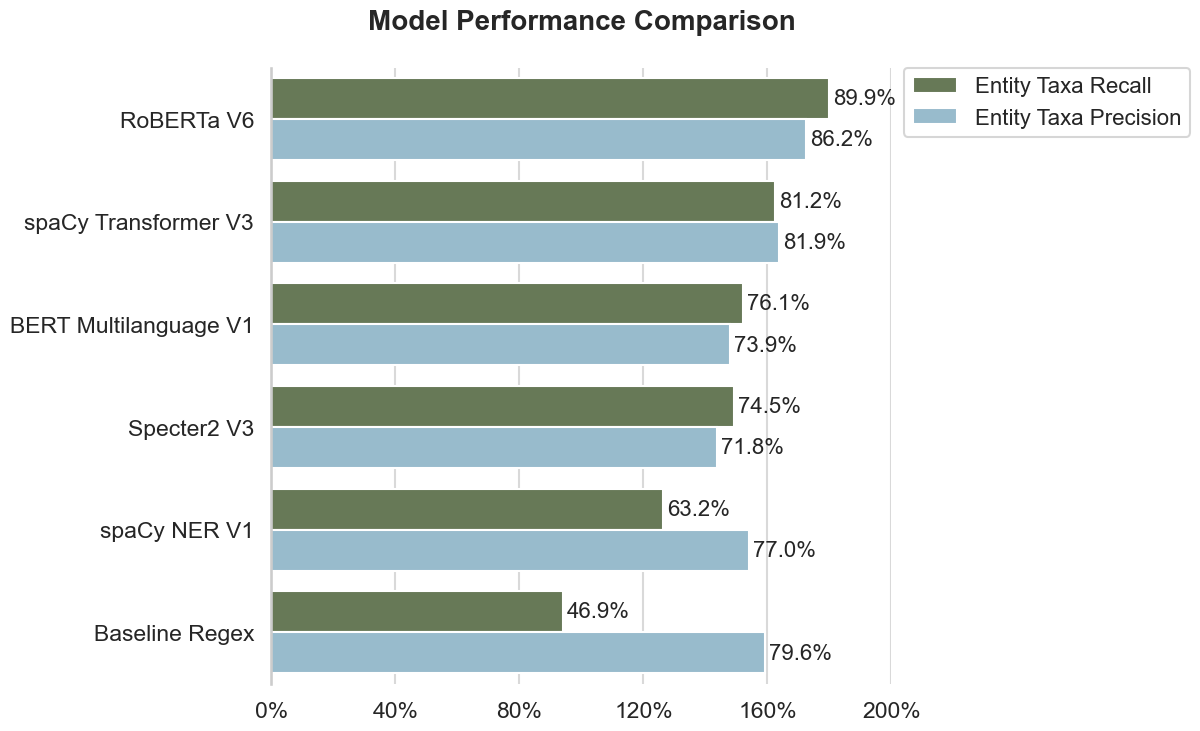

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


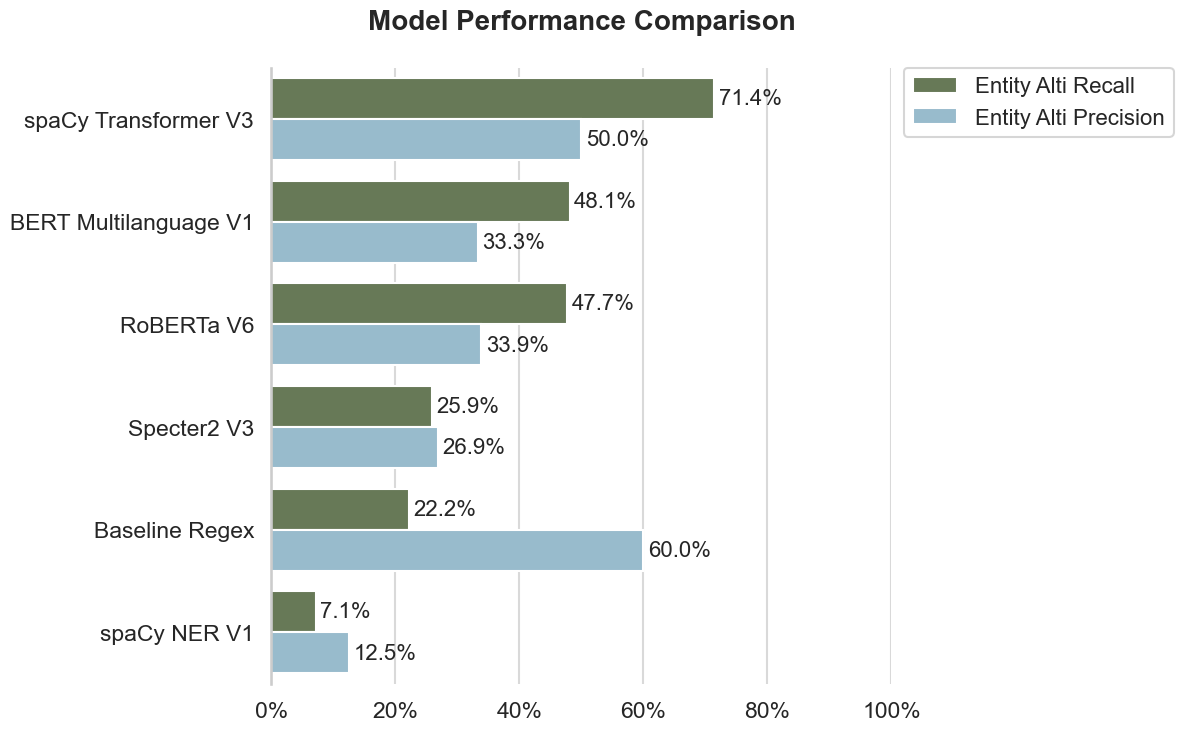

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


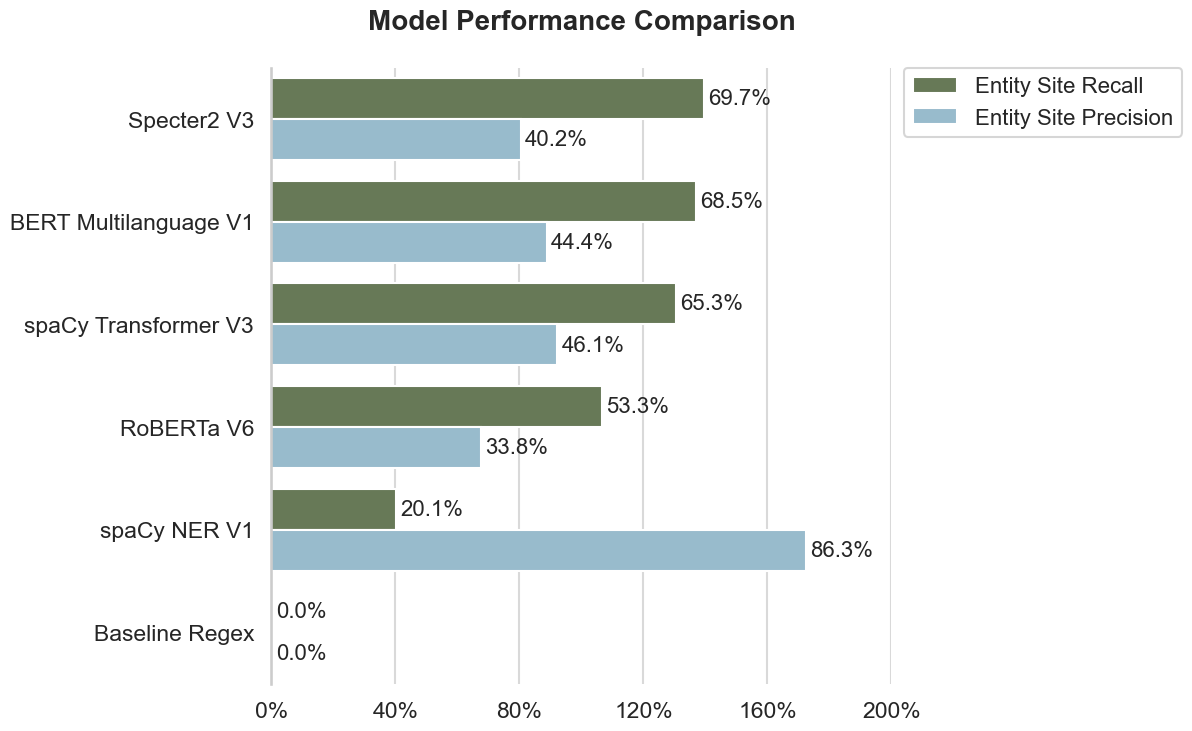

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


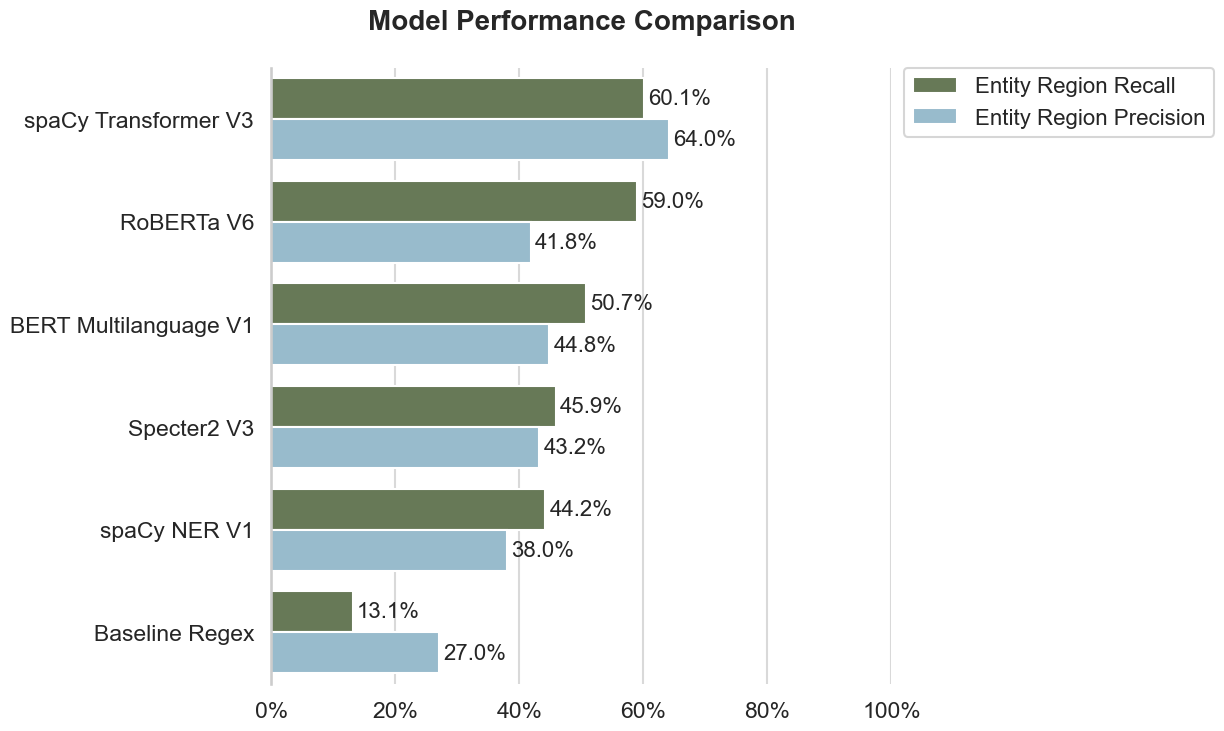

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


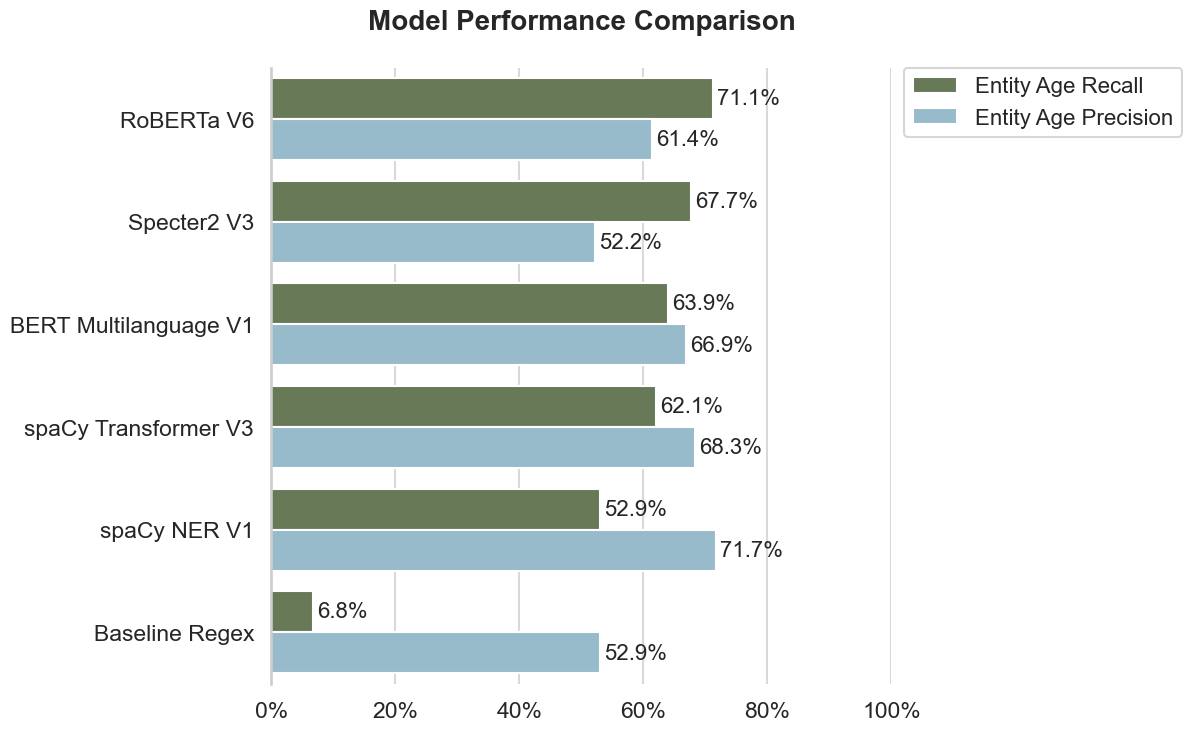

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


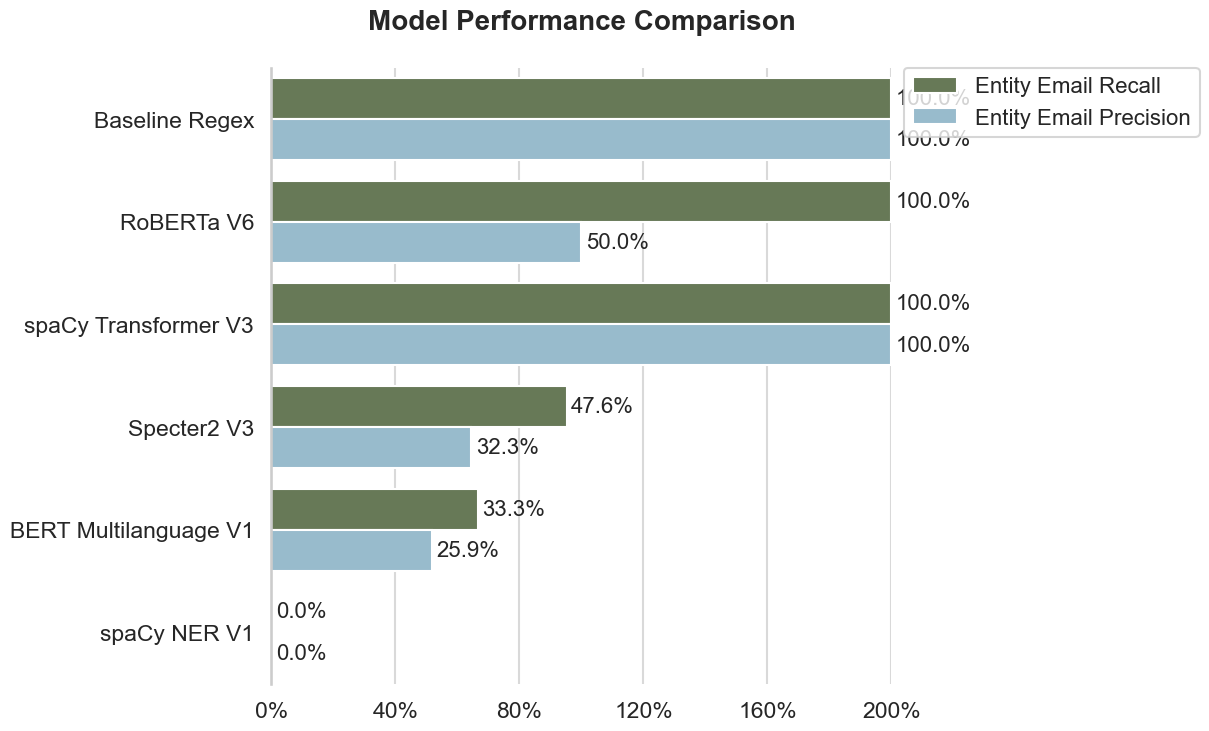

In [71]:
for label in ["GEOG", "TAXA", "ALTI", "SITE", "REGION", "AGE", "EMAIL"]:
    plot_model_metric_comparison(relevant_results, [f"entity_{label}_recall", f"entity_{label}_precision"])

## Token Based Recall & Precision by Entity Type

This is similar to above but looks at purely just individual token matching and not the entity as a whole.

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


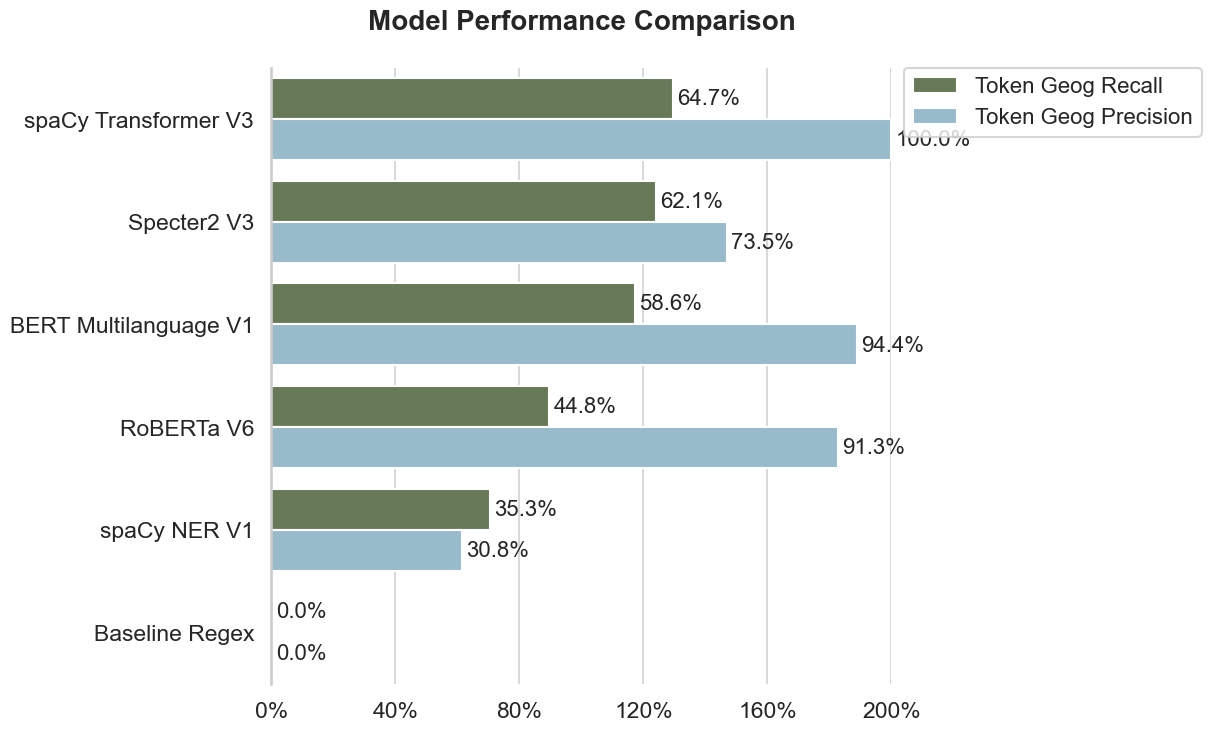

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


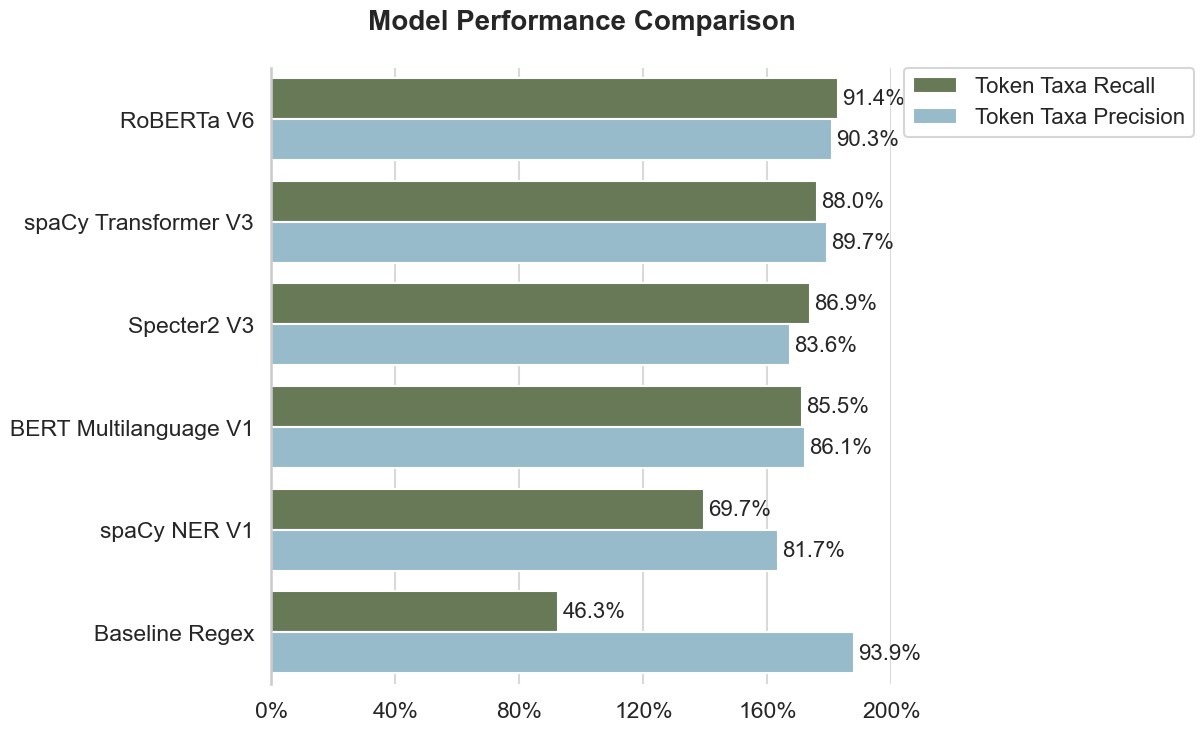

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


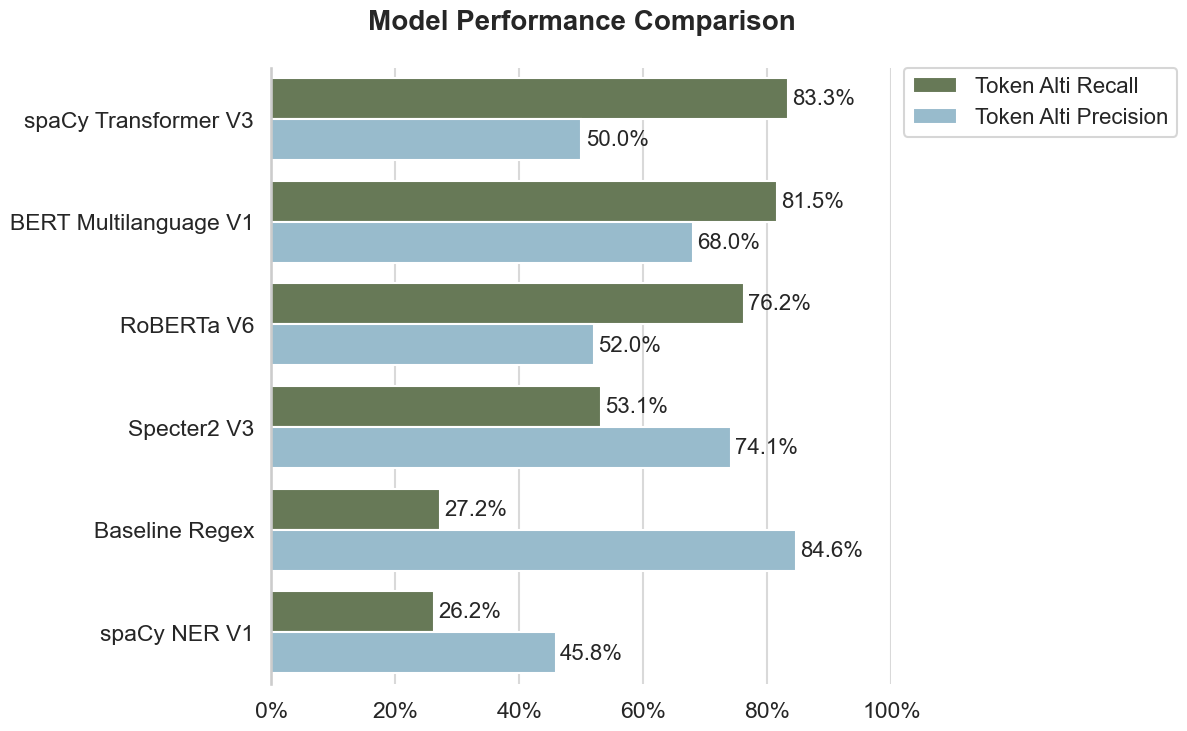

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


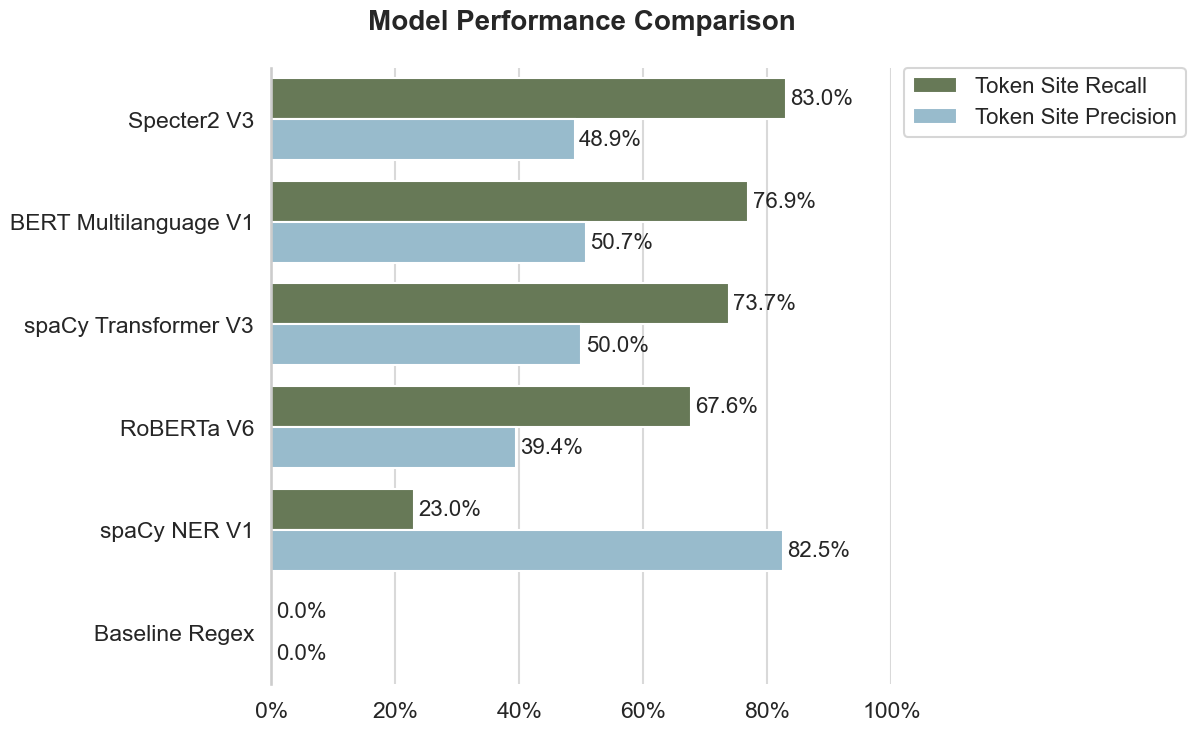

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


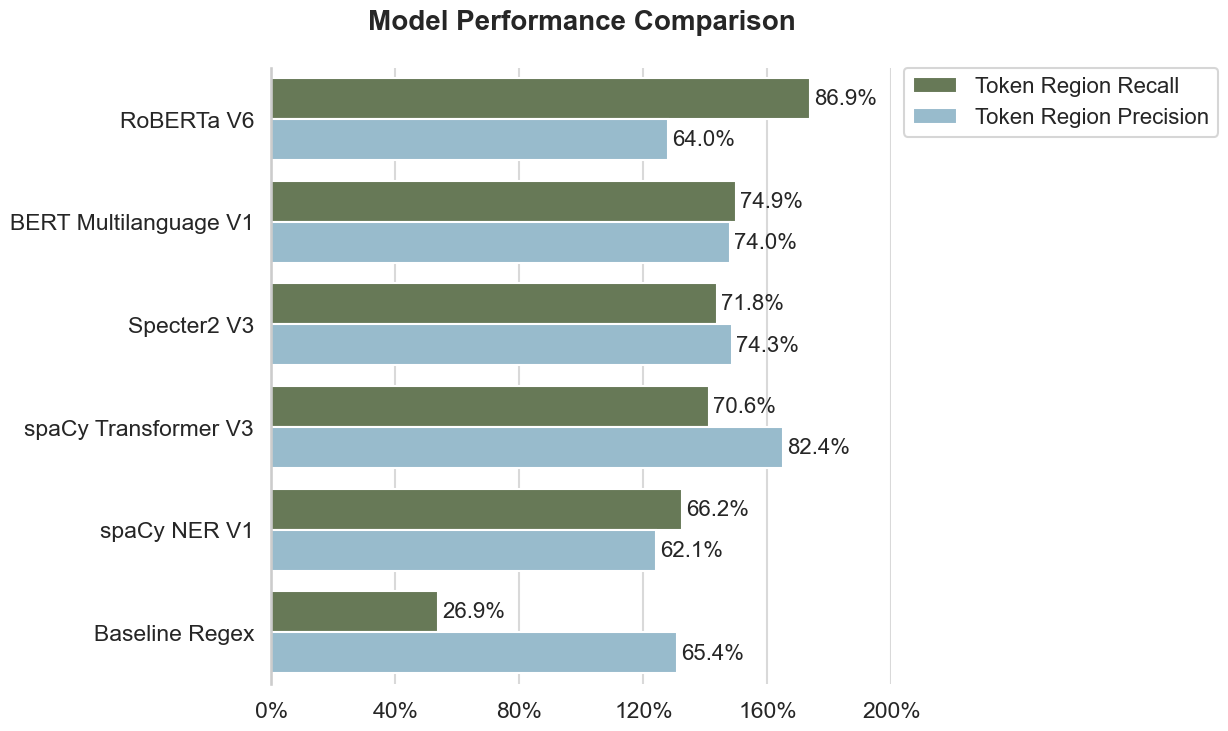

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


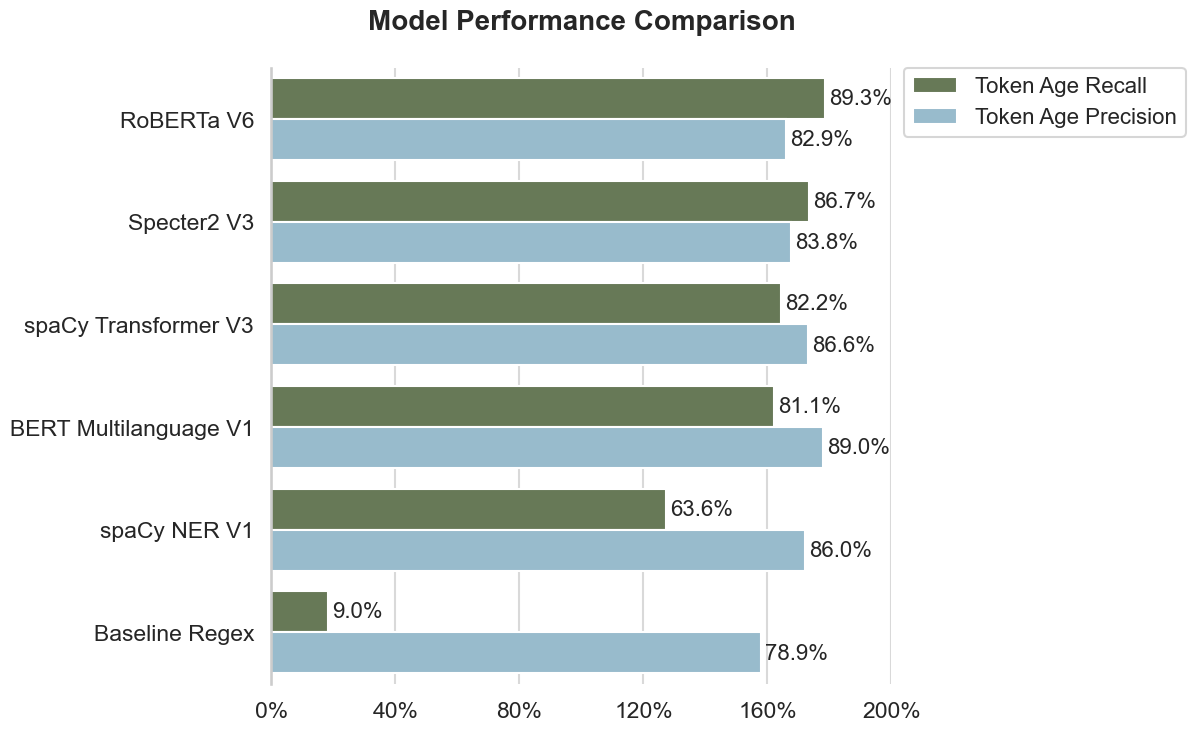

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


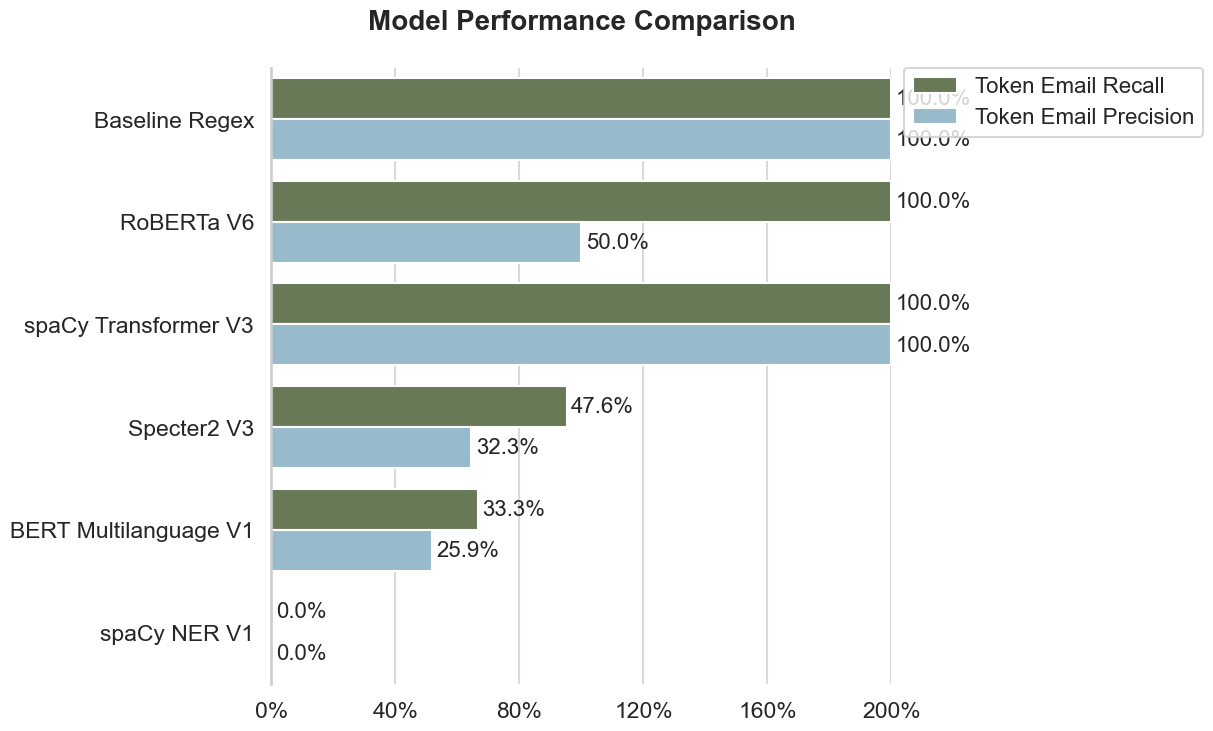

In [72]:
for label in ["GEOG", "TAXA", "ALTI", "SITE", "REGION", "AGE", "EMAIL"]:
    plot_model_metric_comparison(relevant_results, [f"token_{label}_recall", f"token_{label}_precision"])

# Evaluation by Strict, Partial, Exact & Entity-Type Metrics

For more in depth analysis of results the following methods are used to evaluate each model.

+-------------+------------------------------------------------------------------------------------------------------+
| **Method**  | **Description**                                                                                      |
+=============+======================================================================================================+
| **Strict**  | Exact boundary of extracted string and entity type matches the annotation.                           |
+-------------+------------------------------------------------------------------------------------------------------+
| **Exact**   | Exact boundary of extracted string matches but does not discriminate by correct entity label         |
+-------------+------------------------------------------------------------------------------------------------------+
| **Partial** | A partial boundary overlap of the extracted string and does not discriminate by correct entity label |
+-------------+------------------------------------------------------------------------------------------------------+
| **Type**    | Any overlap of the correct entity type is considered correct.                                        |
+-------------+------------------------------------------------------------------------------------------------------+

: Model Evaluation Methods

From the Message Understanding conference the following detailed metrics are used during evaluation for each of the above methods:

+---------------------+-----------------------------------------------------------------------+
| **Metric**          | **Description**                                                       |
+=====================+=======================================================================+
| **Correct (COR)**   | Both the labelled entity and predicted entity are the same            |
+---------------------+-----------------------------------------------------------------------+
| **Incorrect (INC)** | The labelled entity and predicted entity do not match                 |
+---------------------+-----------------------------------------------------------------------+
| **Partial (PAR)**   | The labelled entity and predicted entity are similar but not the same |
+---------------------+-----------------------------------------------------------------------+
| **Missing (MIS)**   | A labelled entity is not captured by the model                        |
+---------------------+-----------------------------------------------------------------------+
| **Spurius (SPU)**   | The model predicts an entity where there is none in the labelled text |
+---------------------+-----------------------------------------------------------------------+

## Strict Recall & Precision

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


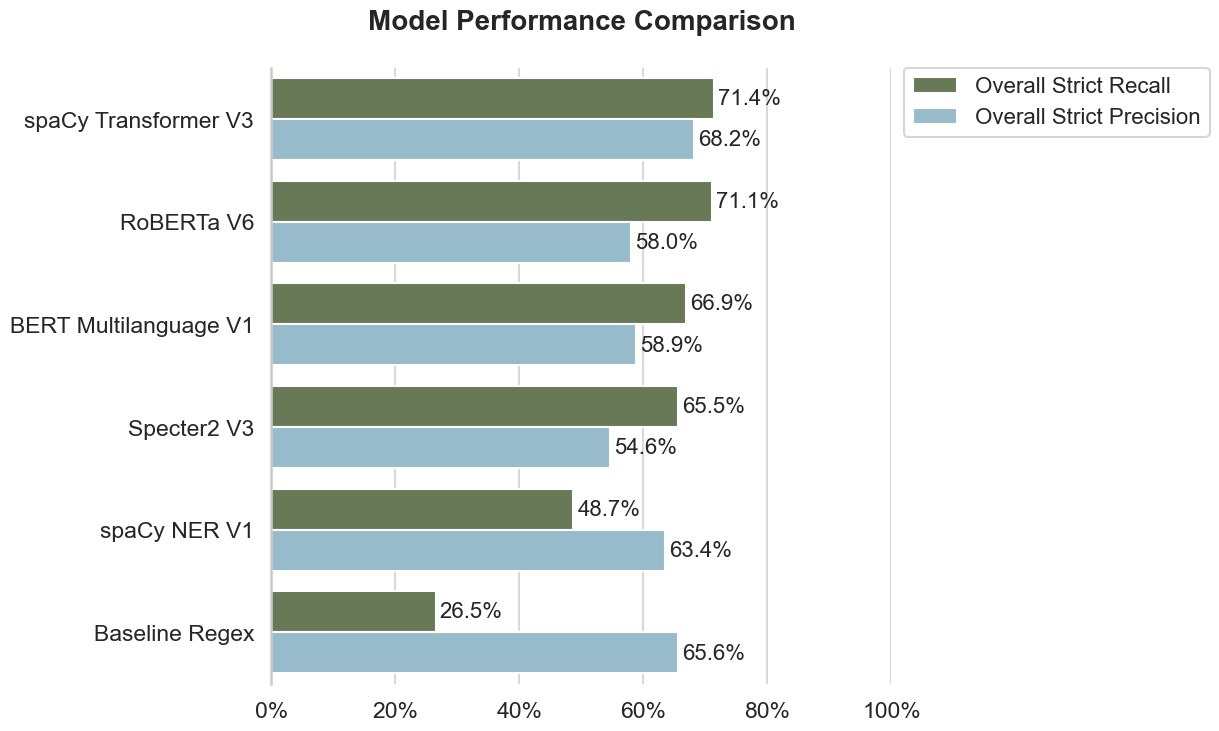

In [73]:
plot_model_metric_comparison(relevant_results, [f"overall_strict_recall", f"overall_strict_precision"])

## Exact Recall & Precision

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


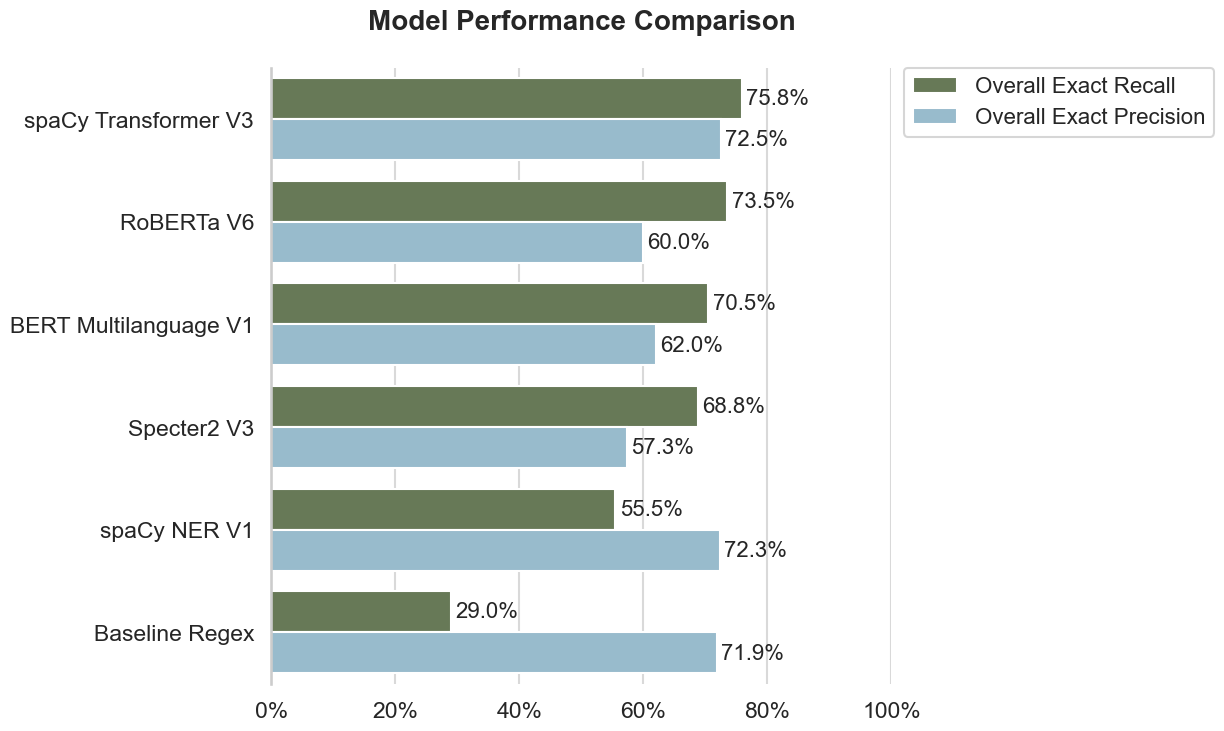

In [74]:
plot_model_metric_comparison(relevant_results, [f"overall_exact_recall", f"overall_exact_precision"])

## Partial Recall & Precision

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


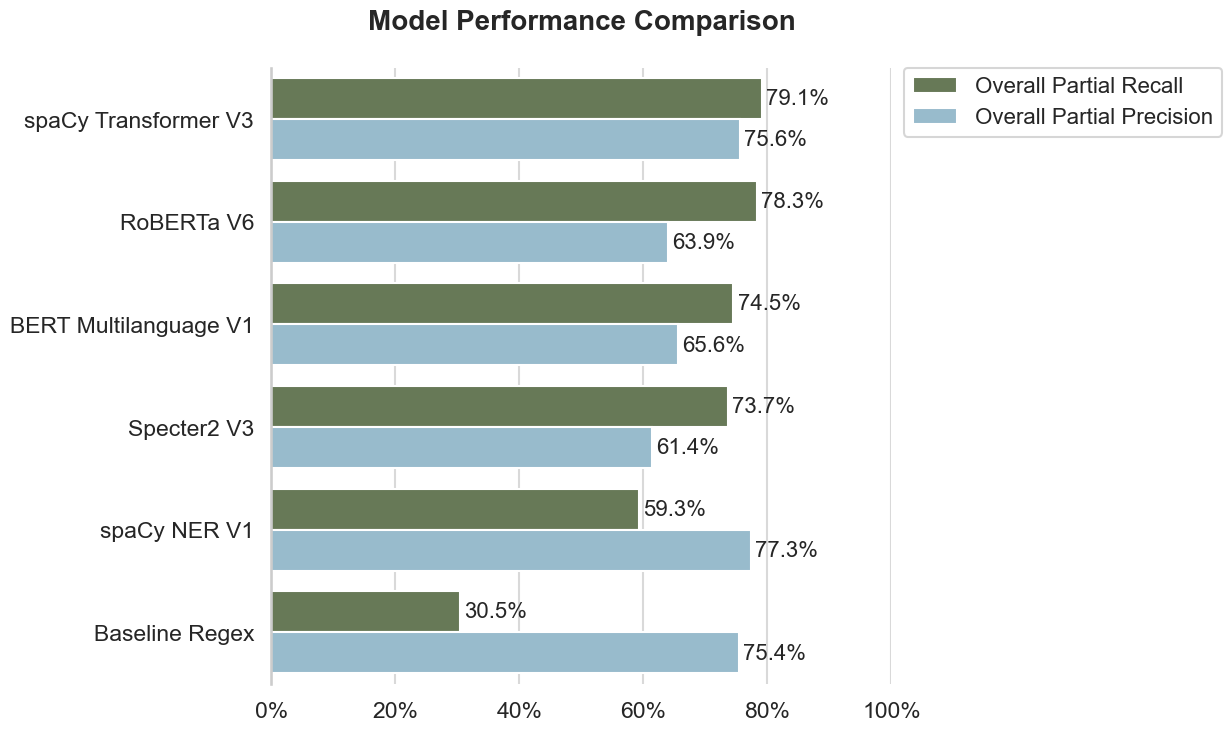

In [75]:
plot_model_metric_comparison(relevant_results, [f"overall_partial_recall", f"overall_partial_precision"])

## Entity Type Recall & Precision

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


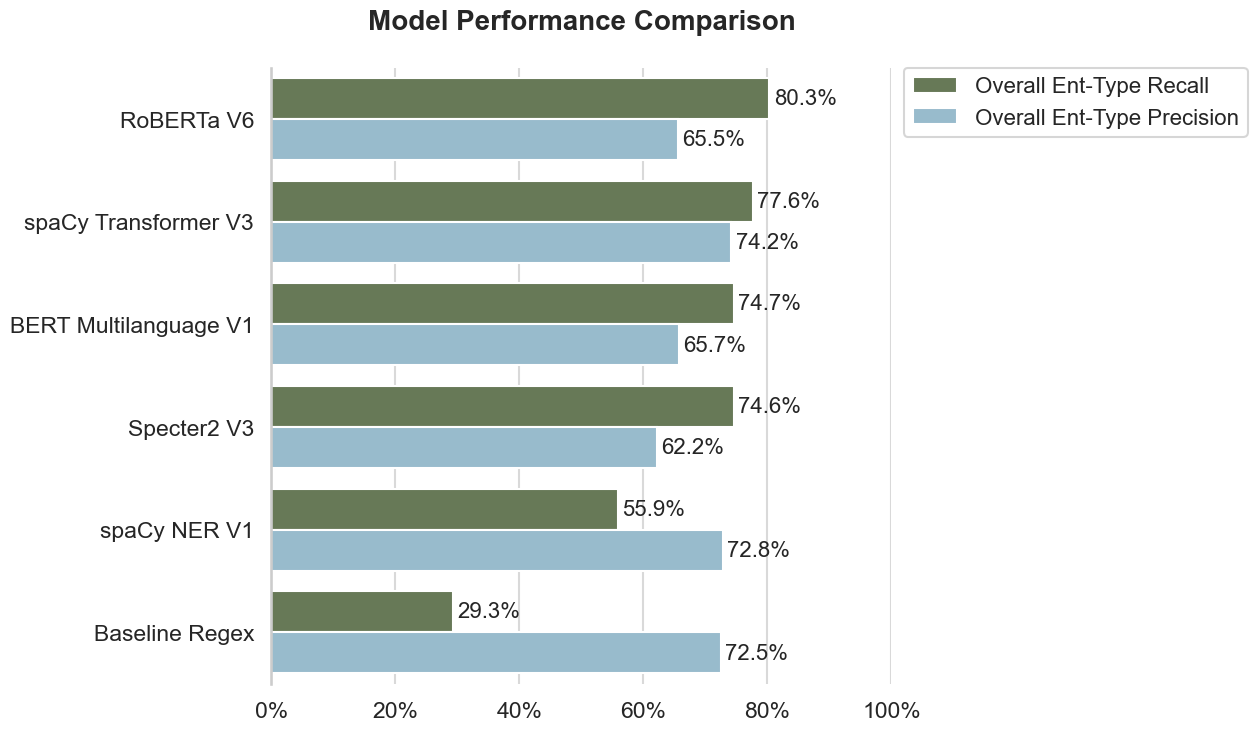

In [76]:
plot_model_metric_comparison(relevant_results, [f"overall_ent-type_recall", f"overall_ent-type_precision"])

# Overall Correct Entities


C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


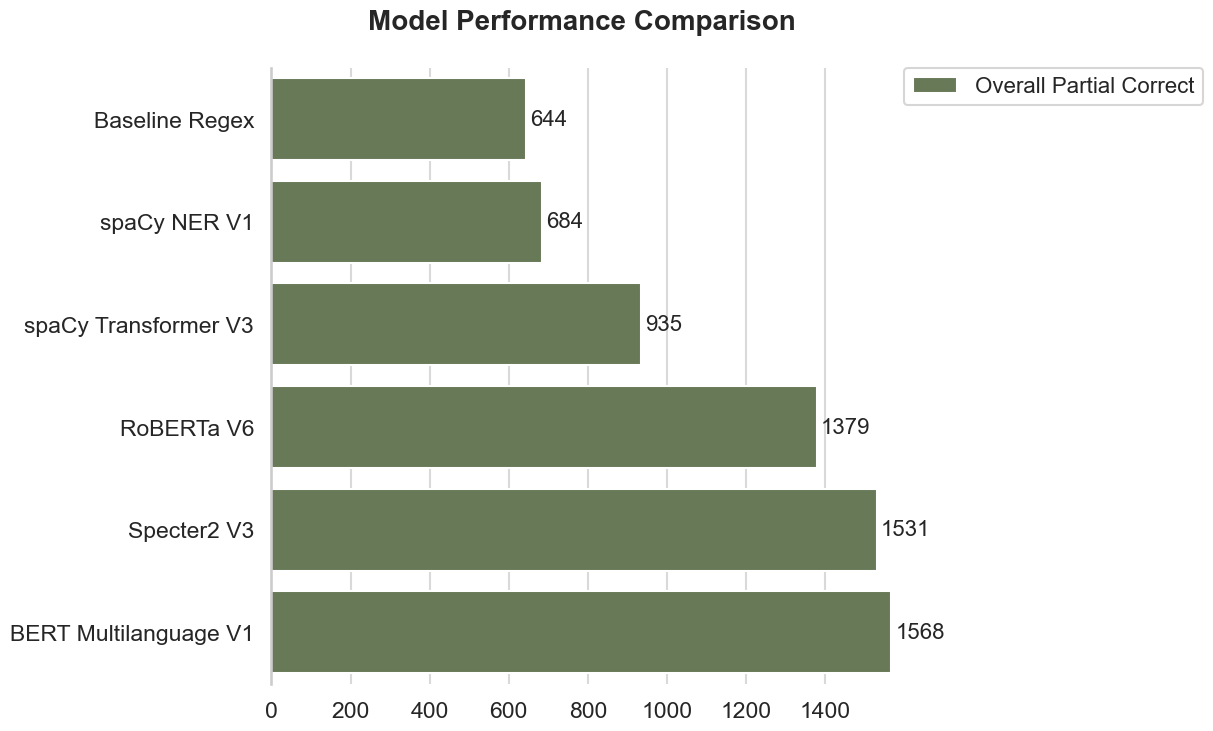

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


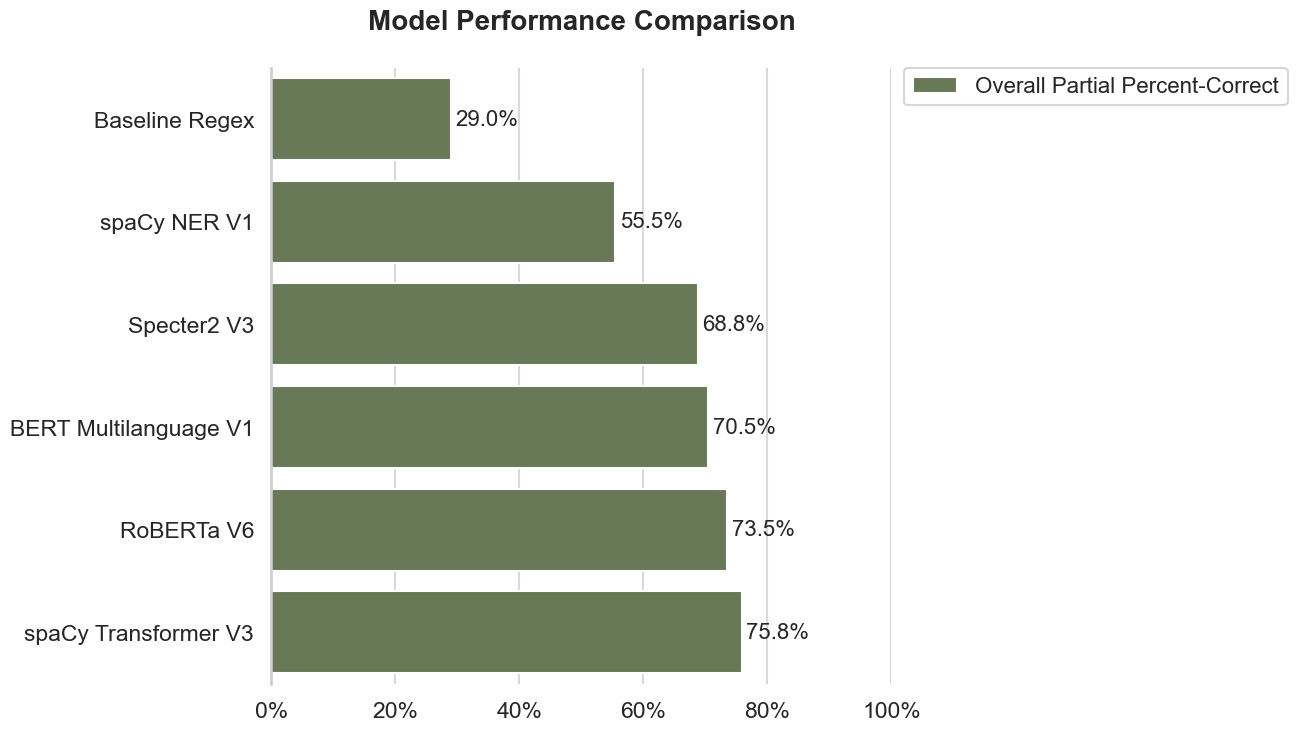

In [77]:
plot_model_metric_comparison(relevant_results, [f"overall_partial_correct"], sort_ascending=True, value_type="count")
plot_model_metric_comparison(relevant_results, [f"overall_partial_percent-correct"], sort_ascending=True, value_type="percent")

# Missed Entities By Model

Each model has missed entities independent of the evaluation method. The following section shows the entities that were missed by each model.

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


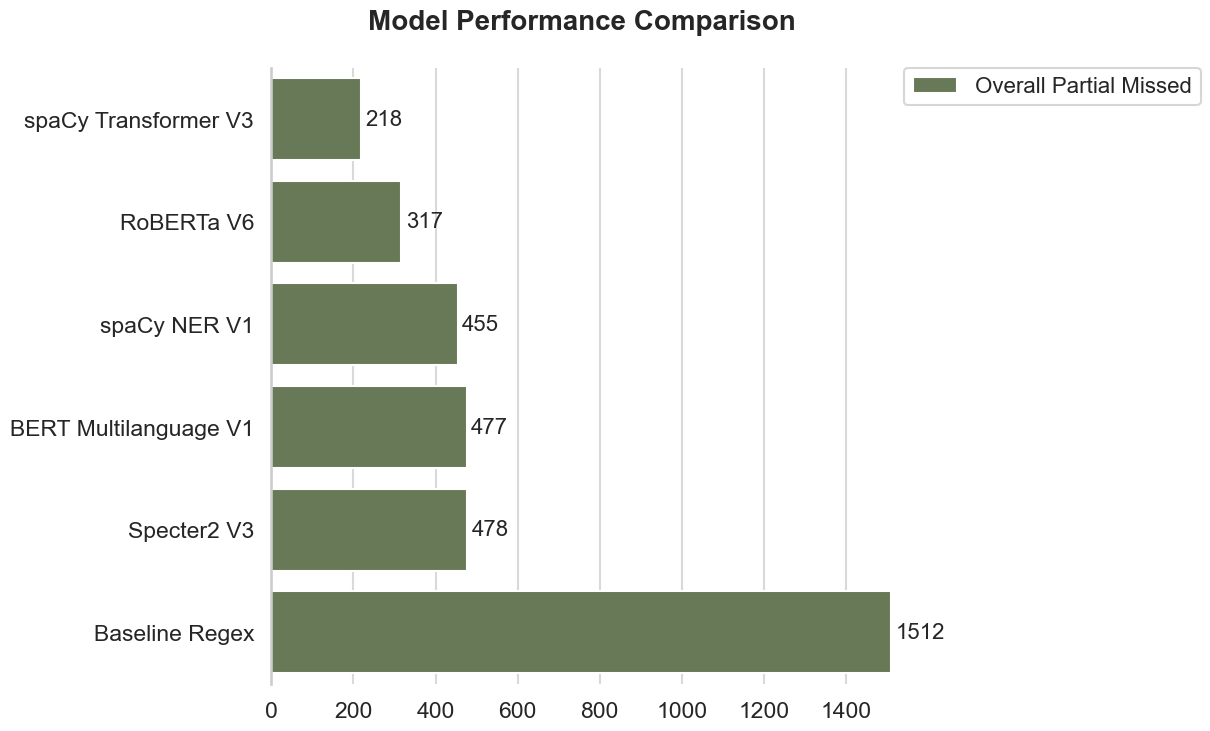

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


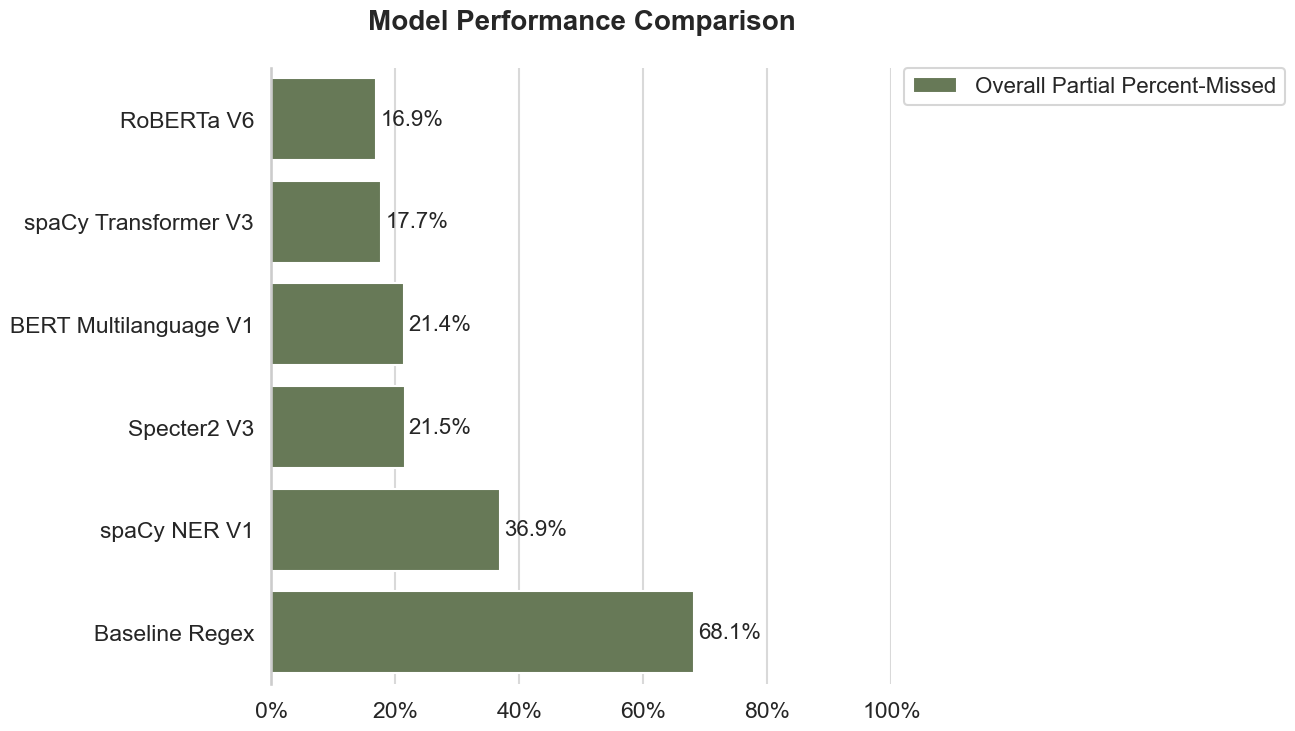

In [78]:
plot_model_metric_comparison(relevant_results, [f"overall_partial_missed"], sort_ascending=True, value_type="count")
plot_model_metric_comparison(relevant_results, [f"overall_partial_percent-missed"], sort_ascending=True, value_type="percent")

## Missed Entities by Entity Type

This may indicate what entities need to be provided with better training data.

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


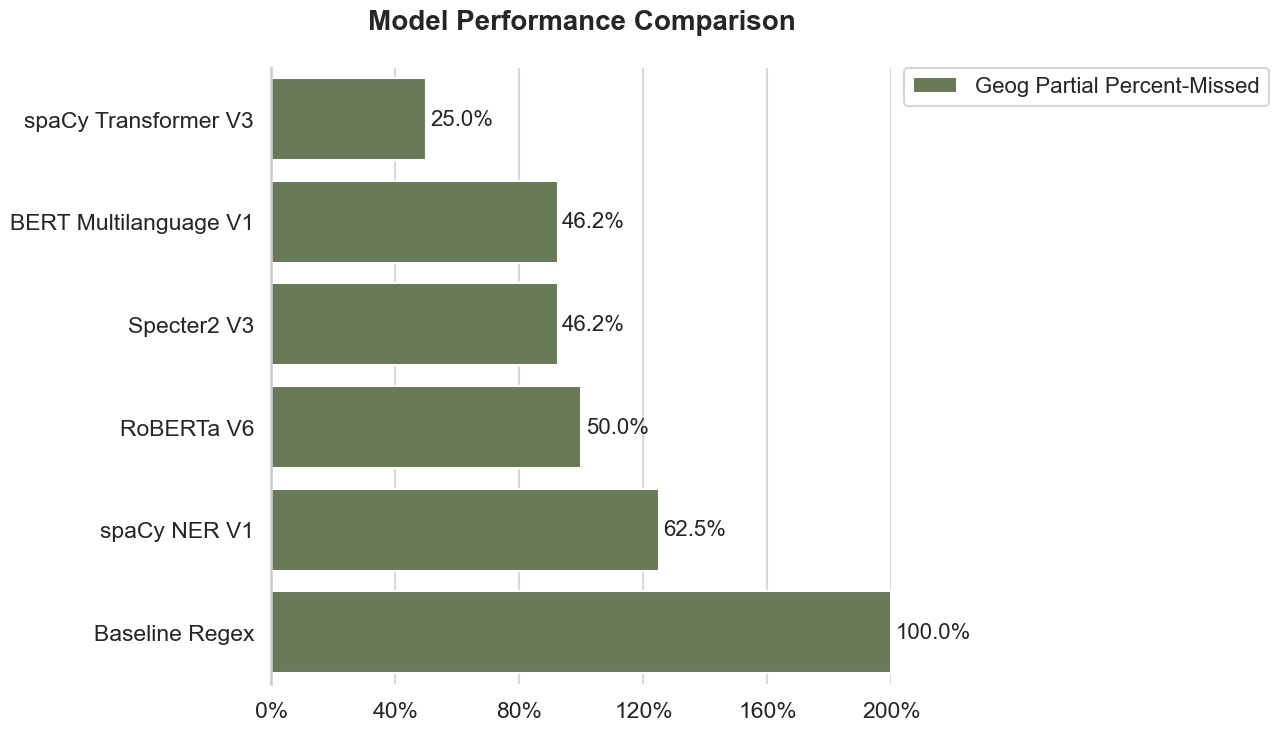

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


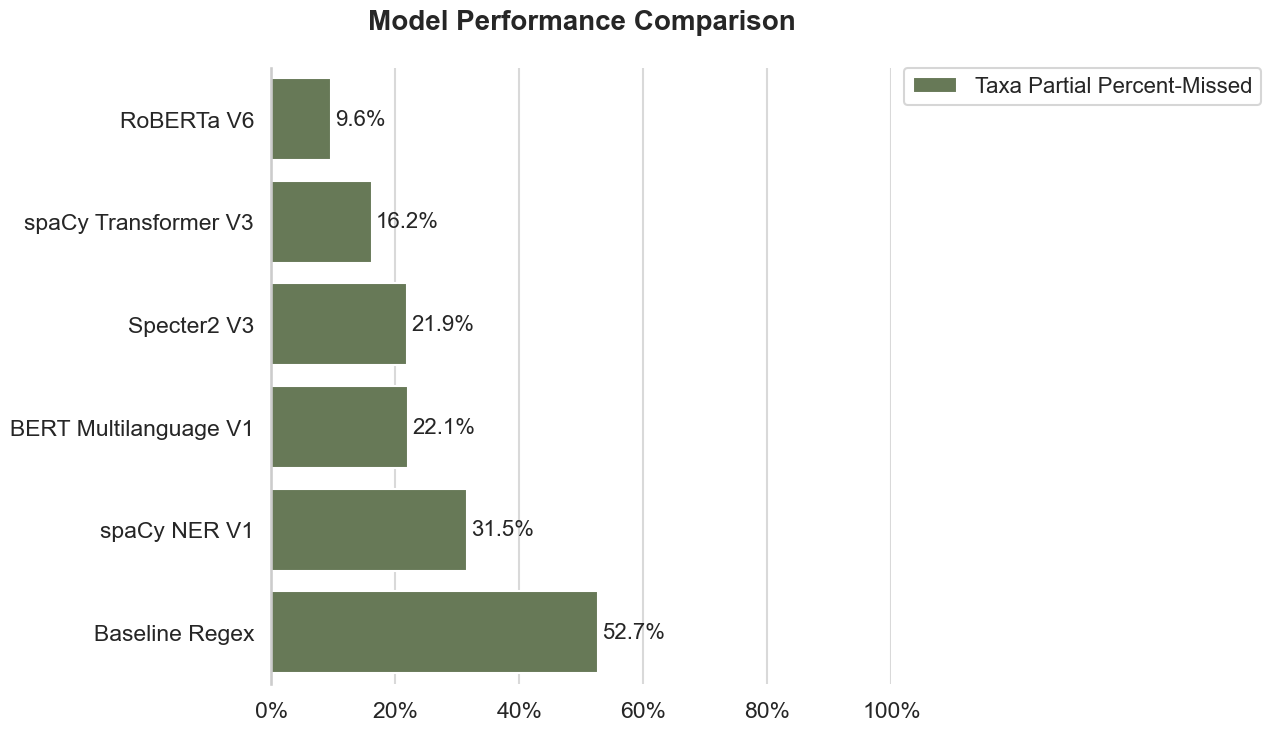

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


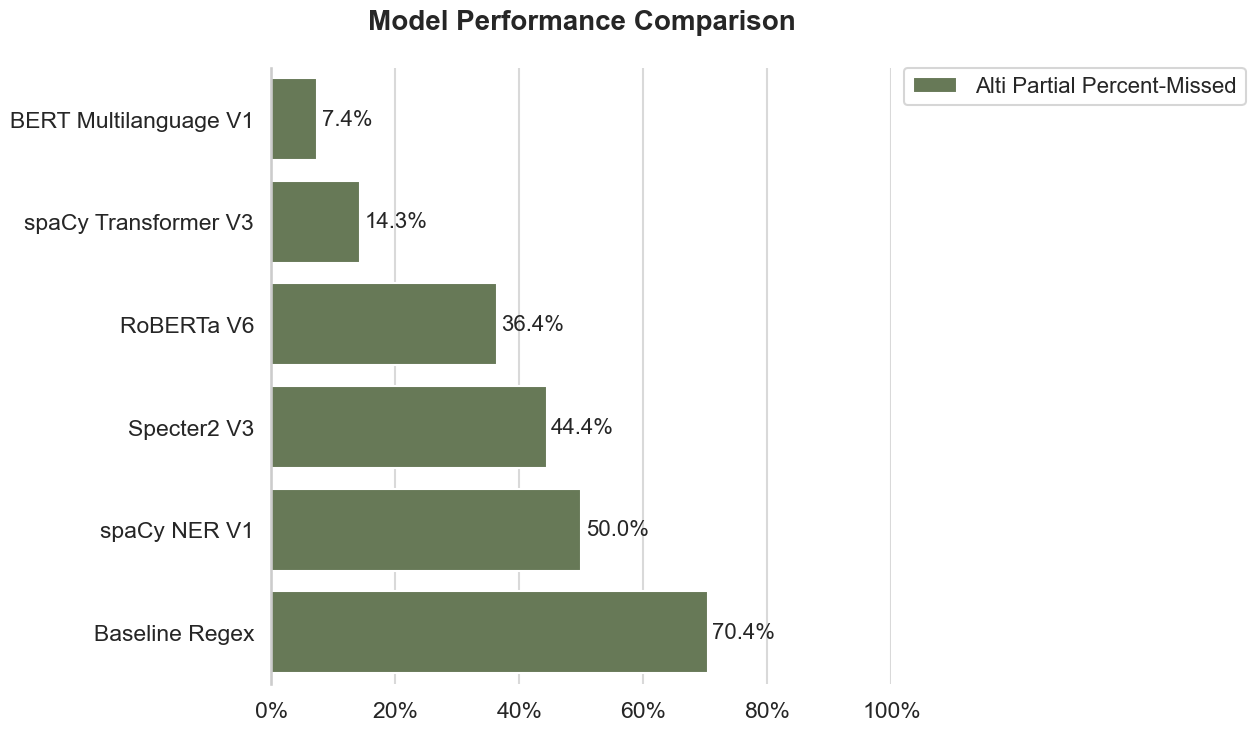

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


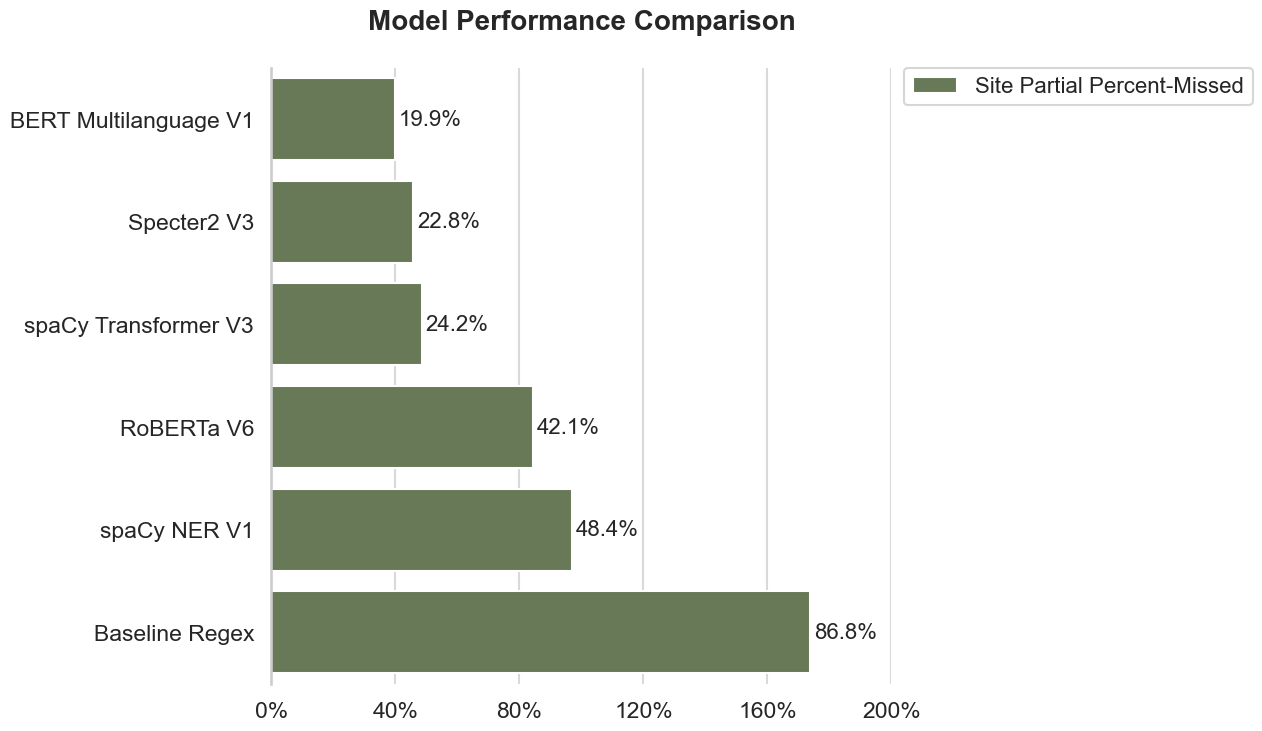

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


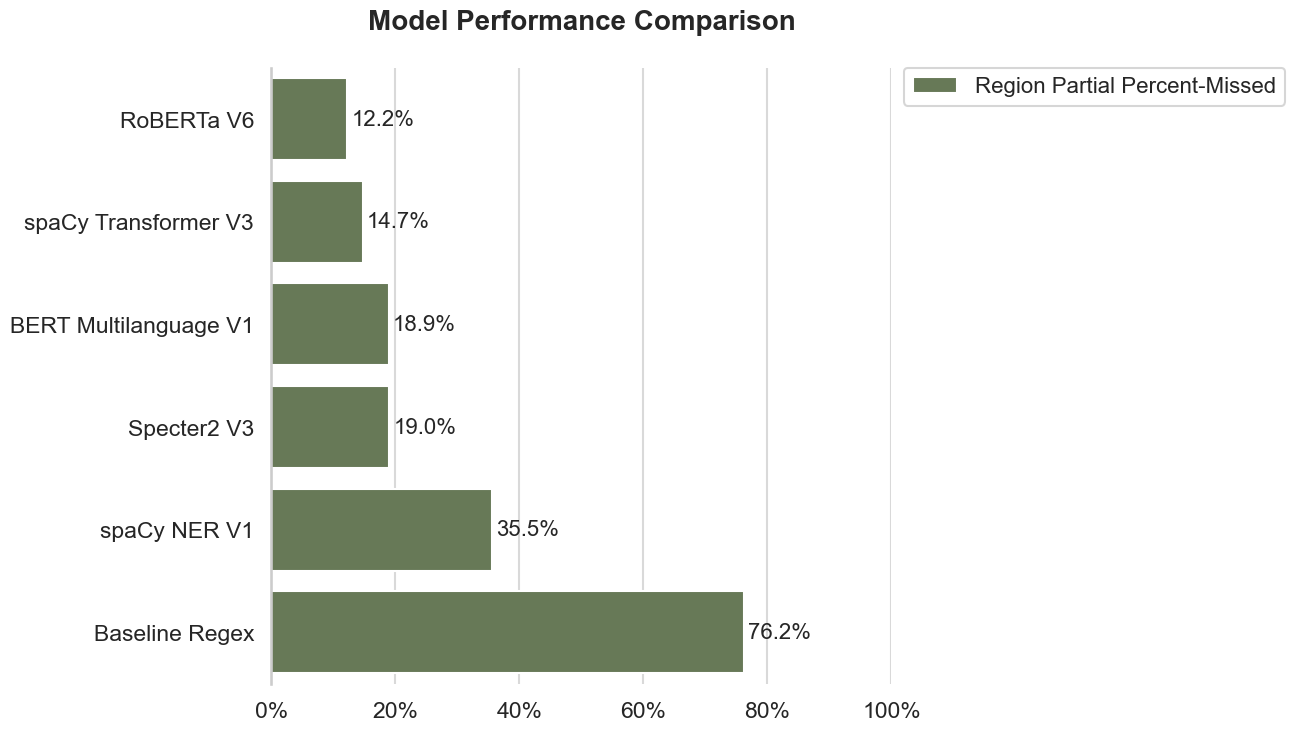

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


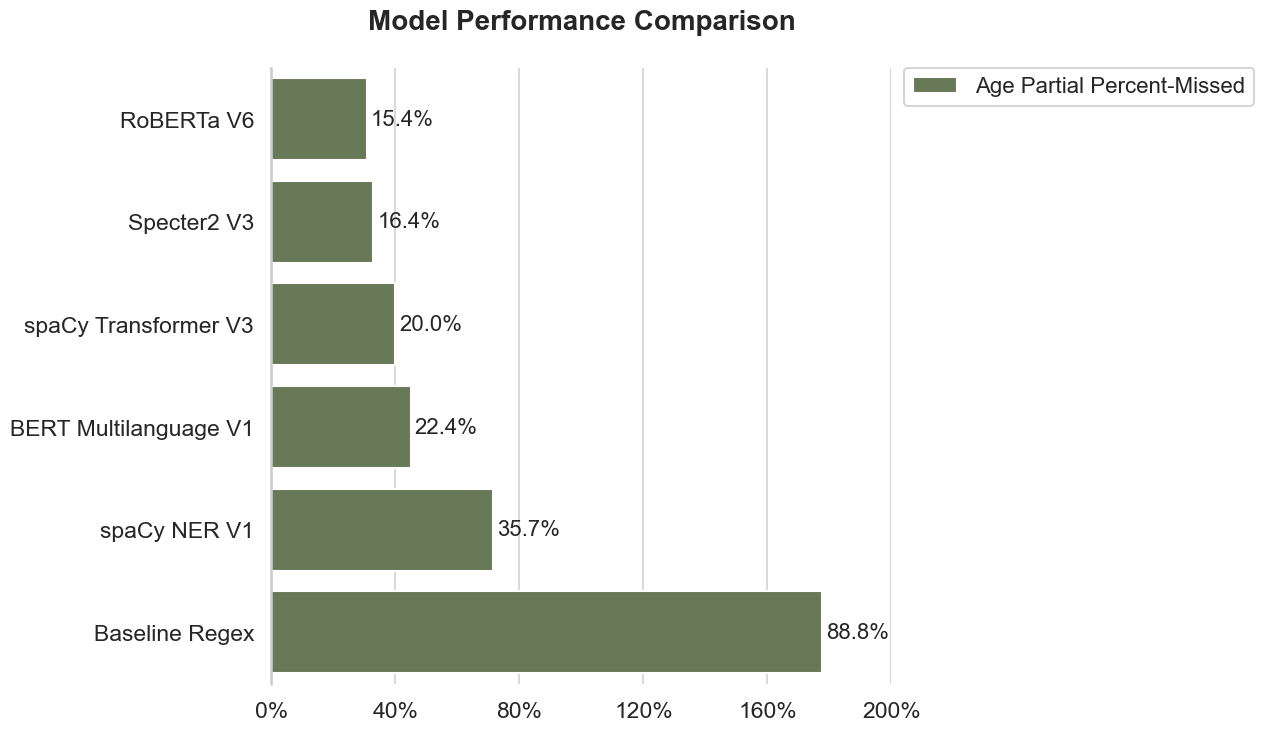

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


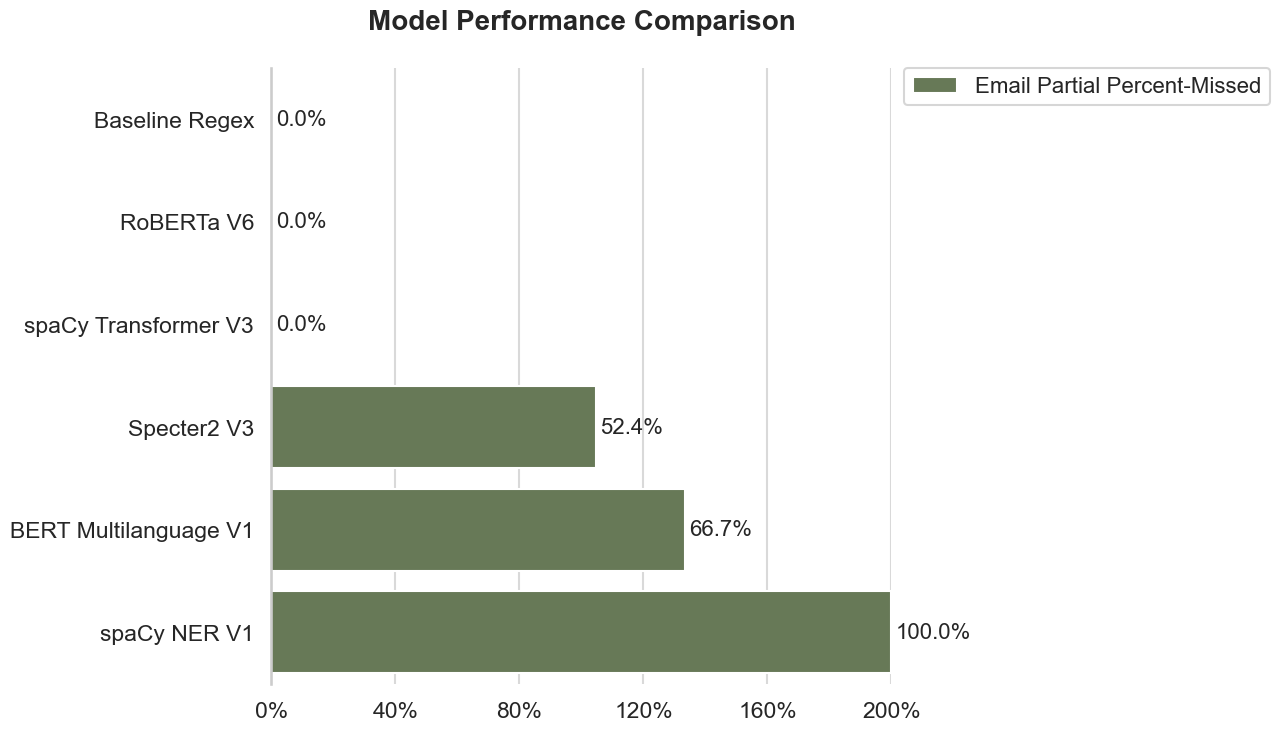

In [79]:
for label in ["GEOG", "TAXA", "ALTI", "SITE", "REGION", "AGE", "EMAIL"]:
    plot_model_metric_comparison(relevant_results, [f"{label}_partial_percent-missed"], sort_ascending=True)

## Number of Spurious Entities by Model

Spurious entities can either indicate completely incorrect entities or entities that got missed during labelling. This was known to be an issue during labelling so these differences don't necessarily reflect the number of entities needing to be deleted by the data stewards.

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


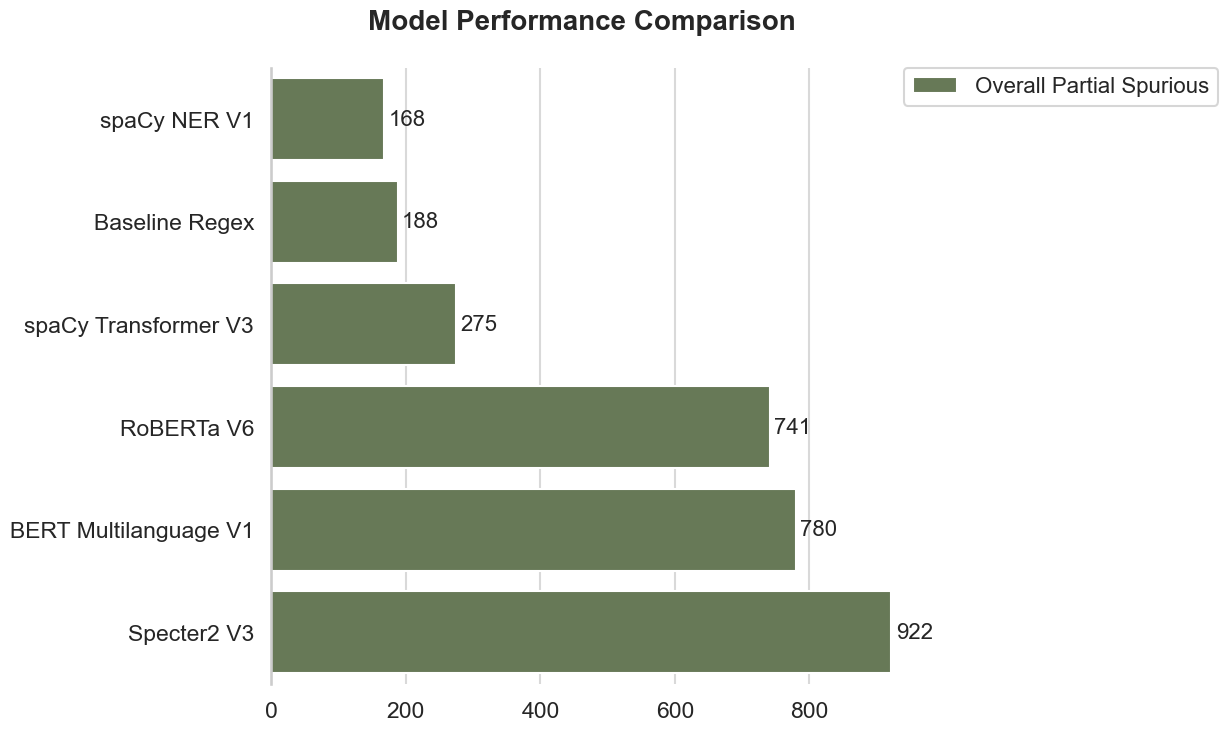

C:\Users\tyand\AppData\Local\Temp\ipykernel_23236\917330151.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


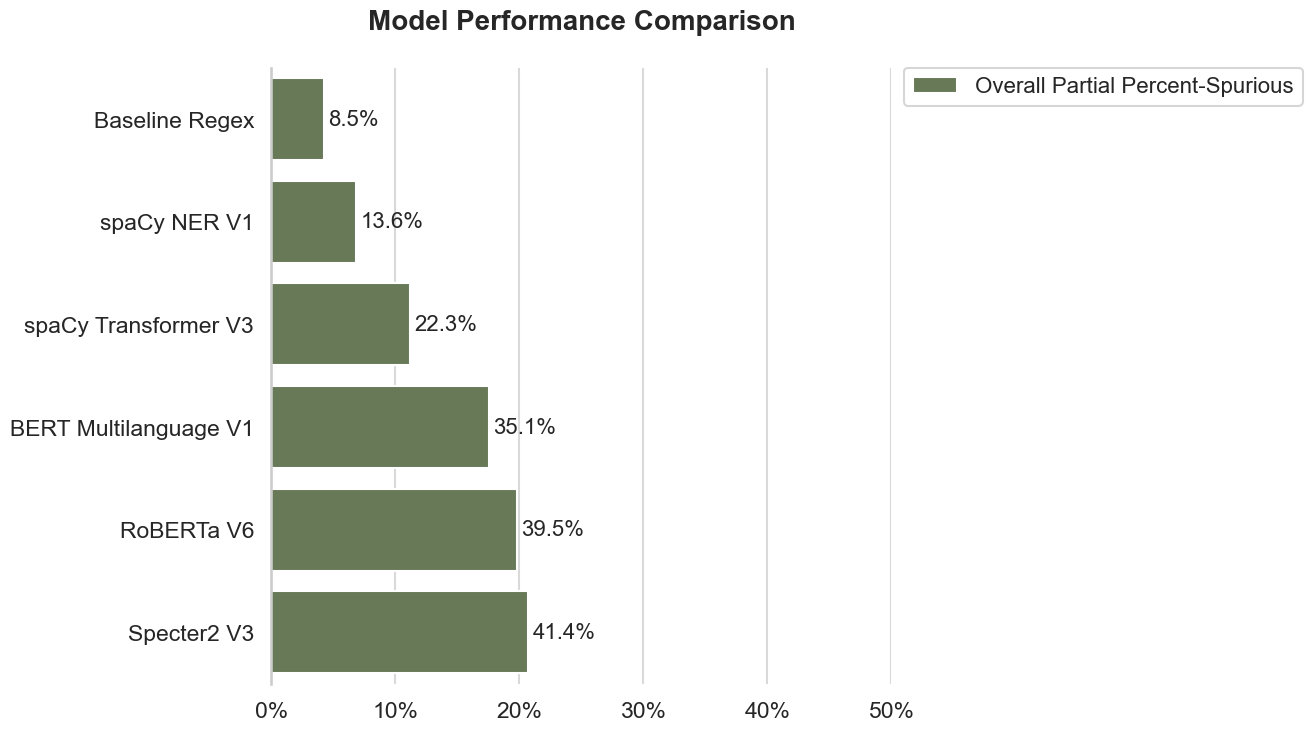

In [80]:
plot_model_metric_comparison(relevant_results, [f"overall_partial_spurious"], sort_ascending=True, value_type="count")
plot_model_metric_comparison(relevant_results, [f"overall_partial_percent-spurious"], sort_ascending=True)